In [1]:
import config
from config import *
%matplotlib inline

#removed element ratios in the second part

2022-02-14 11:53:01.334082: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
class XRF_image:
    
    def __init__(self, xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False):
        self.xrf_filename =xrf_filename
        self.BASE_PATCH_WIDTH=BASE_PATCH_WIDTH
        
        
    def load_xrf_data(self, hdf5_string = 'exchange_4'):
#         global d_Cu, d_Zn, d_Ca, d_K, d_P, d_S,d_Fe, d_Ni, d_TFY
    
        norm_ch = NORM_CH
        value_offset=VALUE_OFFSET
        xrfdata = collections.defaultdict(list)

        with h5py.File(self.xrf_filename, 'r') as dat:
            groups= list(dat.keys())
            maps= list(dat['MAPS'].keys())
            chs = dat['MAPS/channel_names'][:].astype(str).tolist()
        #         dat['MAPS/']
        #         print(chs)



            xrf = dat['MAPS/XRF_roi'][:]
        #         print(xrf)

            scaler_names = dat['MAPS/scaler_names'][:].astype(str).tolist()
            scaler_val = dat['MAPS/scalers'][:]
            norm = scaler_val[scaler_names.index(norm_ch)]
            for e in chs:
                chidx = chs.index(e)
                xrfdata[e].append(xrf[chidx]/norm)
            xrfdata['scan_num'].append(self.xrf_filename)

            hdf5_string = hdf5_string

            xrfdata['x_axis'].append(dat[hdf5_string + '/x_axis'][:])
            xrfdata['y_axis'].append(dat[hdf5_string + '/y_axis'][:])

        #         xrfdata['x_axis'].append(dat['exchange_4/x_axis'][:])
        #         xrfdata['y_axis'].append(dat['exchange_4/y_axis'][:])
        xrfdata = pd.DataFrame(xrfdata)
        #     print(xrfdata)

        elms=['Cu','Zn','Ca', 'K', 'P', 'S','Fe','Ni','TFY']#Default elms
        for i, row in xrfdata.iterrows():
                sc = row['scan_num'][0:row['scan_num'].index('.')]
                for e in elms:
                    d = row[e]

                    d[np.isnan(d) | np.isinf(d)] = 0
                    norm_d = (d - np.min(d)) / (np.max(d) - np.min(d)) + value_offset
                    ss = np.round(np.abs(np.diff(row['x_axis']))[0], 2)
                    if e == 'Cu':
                        self.d_Cu=d
                        self.norm_d_Cu=norm_d
                        x_Cu,y_Cu=row['x_axis'], row['y_axis']
                    if e == 'Zn':
                        self.d_Zn=d
                        self.norm_d_Zn=norm_d
                        x_Zn,y_Zn=row['x_axis'], row['y_axis']
                    if e == 'Ca':
                        self.d_Ca=d
                        self.norm_d_Ca=norm_d
                        x_Ca,y_Ca=row['x_axis'], row['y_axis']
                    if e == 'K':
                        self.d_K=d
                        self.norm_d_K=norm_d
                        x_K,y_K=row['x_axis'], row['y_axis']
                    if e == 'P':
                        self.d_P=d
                        self.norm_d_P=norm_d
                        x_P,y_P=row['x_axis'], row['y_axis']
                    if e == 'S':
                        self.d_S=d
                        self.norm_d_S=norm_d
                        x_S,y_S=row['x_axis'], row['y_axis']

                    if e == 'Fe':
                        self.d_Fe=d
                        self.norm_d_Fe=norm_d
                        x_Fe,y_Fe=row['x_axis'], row['y_axis']

                    if e == 'Ni':
                        self.d_Ni=d
                        self.norm_d_Ni=norm_d
                        x_Ni,y_Ni=row['x_axis'], row['y_axis']

                    if e == 'TFY':
                        self.d_TFY=d
                        self.norm_d_TFY=norm_d
                        x_TFY,y_TFY=row['x_axis'], row['y_axis']
        #     print('Image shape: ',d.shape)
        
        
    def binary_conversion(self, e='Cu'):
        #choose elemental channel for conversion
        
        if e == 'Cu':
            data_original = self.d_Cu
            
        if e == 'Zn':
            data_original = self.d_Zn
            
        if e == 'Ca':
            data_original = self.d_Ca
            
        if e == 'K':
            data_original = self.d_K
            
        if e == 'P':
            data_original = self.d_P
            
        if e == 'S':
            data_original = self.d_S
            

        if e == 'Fe':
            data_original = self.d_Fe
            

        if e == 'Ni':
            data_original = self.d_Ni
            
        if e == 'TFY':
            data_original = self.d_TFY
            
#         data_original=d_Cu
        data=data_original
        data = ndimage.median_filter(data, size=3)


        thresh = 1.5*threshold_otsu(data)
        binary = data < thresh
        binary = binary^1


        binary_eroded=ndimage.binary_erosion(binary).astype(binary.dtype)
        binary_dilated=ndimage.binary_dilation(binary).astype(binary.dtype)
        self.binary_ero_dil=ndimage.binary_dilation(binary_eroded).astype(binary_eroded.dtype)
        
        self.labeled_array, self.num_features = label(self.binary_ero_dil)
        
    def extract_cells(self):
        self.regions = measure.regionprops(self.labeled_array)    
        # print(len(regions))

        self.cell_list = []
        self.center_list = []
        self.Patches_Cu = []
        self.Patches_Zn = []
        self.Patches_Ca = []
        self.Patches_K = []
        self.Patches_P = []
        self.Patches_S = []
        self.Patches_Fe = []
        self.Patches_Ni = []
        self.Patches_TFY= []
        self.binary_img=[]
        self.region_vals=[]
        self.features_list = []

        for idx in range(len(self.regions)):
            self.cell_val_bin=self.regions[idx].image

            self.region_vals.append(self.cell_val_bin)
            self.padded_cell = np.pad(self.cell_val_bin, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.cell_list.append(self.padded_cell)
            self.center_list.append([math.floor(self.regions[idx].centroid[0]), math.floor(self.regions[idx].centroid[1])])
        #     regions[idx].bbox

            self.cell_Cu = self.d_Cu[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Zn = self.d_Zn[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Ca = self.d_Ca[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_K = self.d_K[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_P = self.d_P[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_S = self.d_S[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Fe = self.d_Fe[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Ni = self.d_Ni[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_TFY = self.d_TFY[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]

            self.padded_bin = np.pad(self.cell_val_bin, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Cu = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Zn = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Ca = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_K = np.pad(self.cell_K, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_P = np.pad(self.cell_P, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_S = np.pad(self.cell_S, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Fe = np.pad(self.cell_Fe, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Ni = np.pad(self.cell_Ni, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_TFY = np.pad(self.cell_TFY, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))

            self.binary_img.append(self.padded_bin)
            self.Patches_Cu.append(self.padded_Cu)
            self.Patches_Zn.append(self.padded_Zn)
            self.Patches_Ca.append(self.padded_Ca)
            self.Patches_K.append(self.padded_K)
            self.Patches_P.append(self.padded_P)
            self.Patches_S.append(self.padded_S)
            self.Patches_Fe.append(self.padded_Fe)
            self.Patches_Ni.append(self.padded_Ni)
            self.Patches_TFY.append(self.padded_TFY)


            # define feature vector using averages
        #     x = np.asarray([regions[idx].area, 
        #      regions[idx].eccentricity, 
        #      regions[idx].equivalent_diameter, 
        #      regions[idx].major_axis_length,
        #      regions[idx].minor_axis_length,
        #      regions[idx].perimeter,
        #      np.average(Patches_K[idx]),
        #      np.average(Patches_K[idx])/np.average(Patches_P[idx]),
        #      np.average(Patches_Ni[idx]),
        #      np.average(Patches_Ni[idx])/np.average(Patches_P[idx]),
        #     np.average(Patches_Ni[idx])/np.average(Patches_K[idx]),
        #     np.average(Patches_Cu[idx])/np.average(Patches_K[idx]),
        #     ])

            # define feature vector using averages
            self.x = np.asarray([0.25*0.25*self.regions[idx].area, 
             self.regions[idx].eccentricity, 
             0.25*self.regions[idx].equivalent_diameter, 
             0.25*self.regions[idx].major_axis_length,
             0.25*self.regions[idx].minor_axis_length,
             0.25*self.regions[idx].perimeter,
             np.amax(self.Patches_K[idx]),
             np.amax(self.Patches_K[idx])/np.amax(self.Patches_P[idx]),
             np.amax(self.Patches_Ni[idx]),
             np.amax(self.Patches_Ni[idx])/np.amax(self.Patches_P[idx]),
            np.amax(self.Patches_Ni[idx])/np.amax(self.Patches_Zn[idx]),
            np.amax(self.Patches_Ni[idx])/np.amax(self.Patches_Fe[idx]),
            np.amax(self.Patches_Ni[idx])/np.amax(self.Patches_K[idx]),
            np.amax(self.Patches_Cu[idx])/np.amax(self.Patches_K[idx]),
            np.amax(self.Patches_TFY[idx]-self.Patches_K[idx]-self.Patches_Ni[idx]-self.Patches_Cu[idx]-self.Patches_Zn[idx]-self.Patches_Fe[idx])                     
            ])

            self.features_list.append(self.x)
        self.features=np.asarray(self.features_list)



In [3]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin1=x.binary_img
X1=x.features
X1.shape

(110, 15)

In [4]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_3.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='K')
x.extract_cells()
X_bin2=x.binary_img
X2=x.features
X2.shape

(41, 15)

In [5]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0003_2018_3.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='K')
x.extract_cells()
X_bin3=x.binary_img
X3=x.features
X3.shape

(43, 15)

In [6]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0012_2018_1w2.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin4=x.binary_img
X4=x.features
X4.shape

(53, 15)

In [7]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0014_2018_1w2.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin5=x.binary_img
X5=x.features
X5.shape

(55, 15)

In [8]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0040_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin6=x.binary_img
X6=x.features
X6.shape

(39, 15)

In [9]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0050_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin7=x.binary_img
X7=x.features
X7.shape

(57, 15)

In [10]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0051_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin8=x.binary_img
X8=x.features
X8.shape

(61, 15)

In [11]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0052_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin9=x.binary_img
X9=x.features
X9.shape

(31, 15)

In [12]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0065_2018_3.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='K')
x.extract_cells()
X_bin10=x.binary_img
X10=x.features
X10.shape

(64, 15)

In [13]:
X=np.concatenate((X1,X2,X3,X4,X5,X6,X7,X8,X9,X10))
X_bin=np.concatenate((X_bin1,X_bin2,X_bin3,X_bin4,X_bin5,X_bin6,X_bin7,X_bin8,X_bin9,X_bin10))

In [14]:
X.shape

(554, 15)

In [15]:
X_bin.shape

(554, 32, 32)

In [68]:
def viewer(idx):

    plt.imshow(X_bin[idx]);

    
    plt.title('Binary image')
    plt.colorbar()
#     plt.ylim(-0.5, 5)
#     plt.grid(True)
    plt.show()

interactive_plot = interactive(viewer, idx=(0, len(X_bin)-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=276, description='idx', max=553), Output()), _dom_classes=('widget-inter…

In [17]:
X[0]

array([3.12500000e-01, 0.00000000e+00, 6.30783131e-01, 6.32455532e-01,
       6.32455532e-01, 1.41421356e+00, 2.85727874e-05, 9.52823699e-01,
       2.86160812e-05, 9.54267442e-01, 2.85584442e-02, 4.05041665e-01,
       1.00151527e+00, 3.50689697e+01, 1.52614368e-02])

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_standard = StandardScaler().fit_transform(X)

# reduced_X = PCA(=2).fit(X)

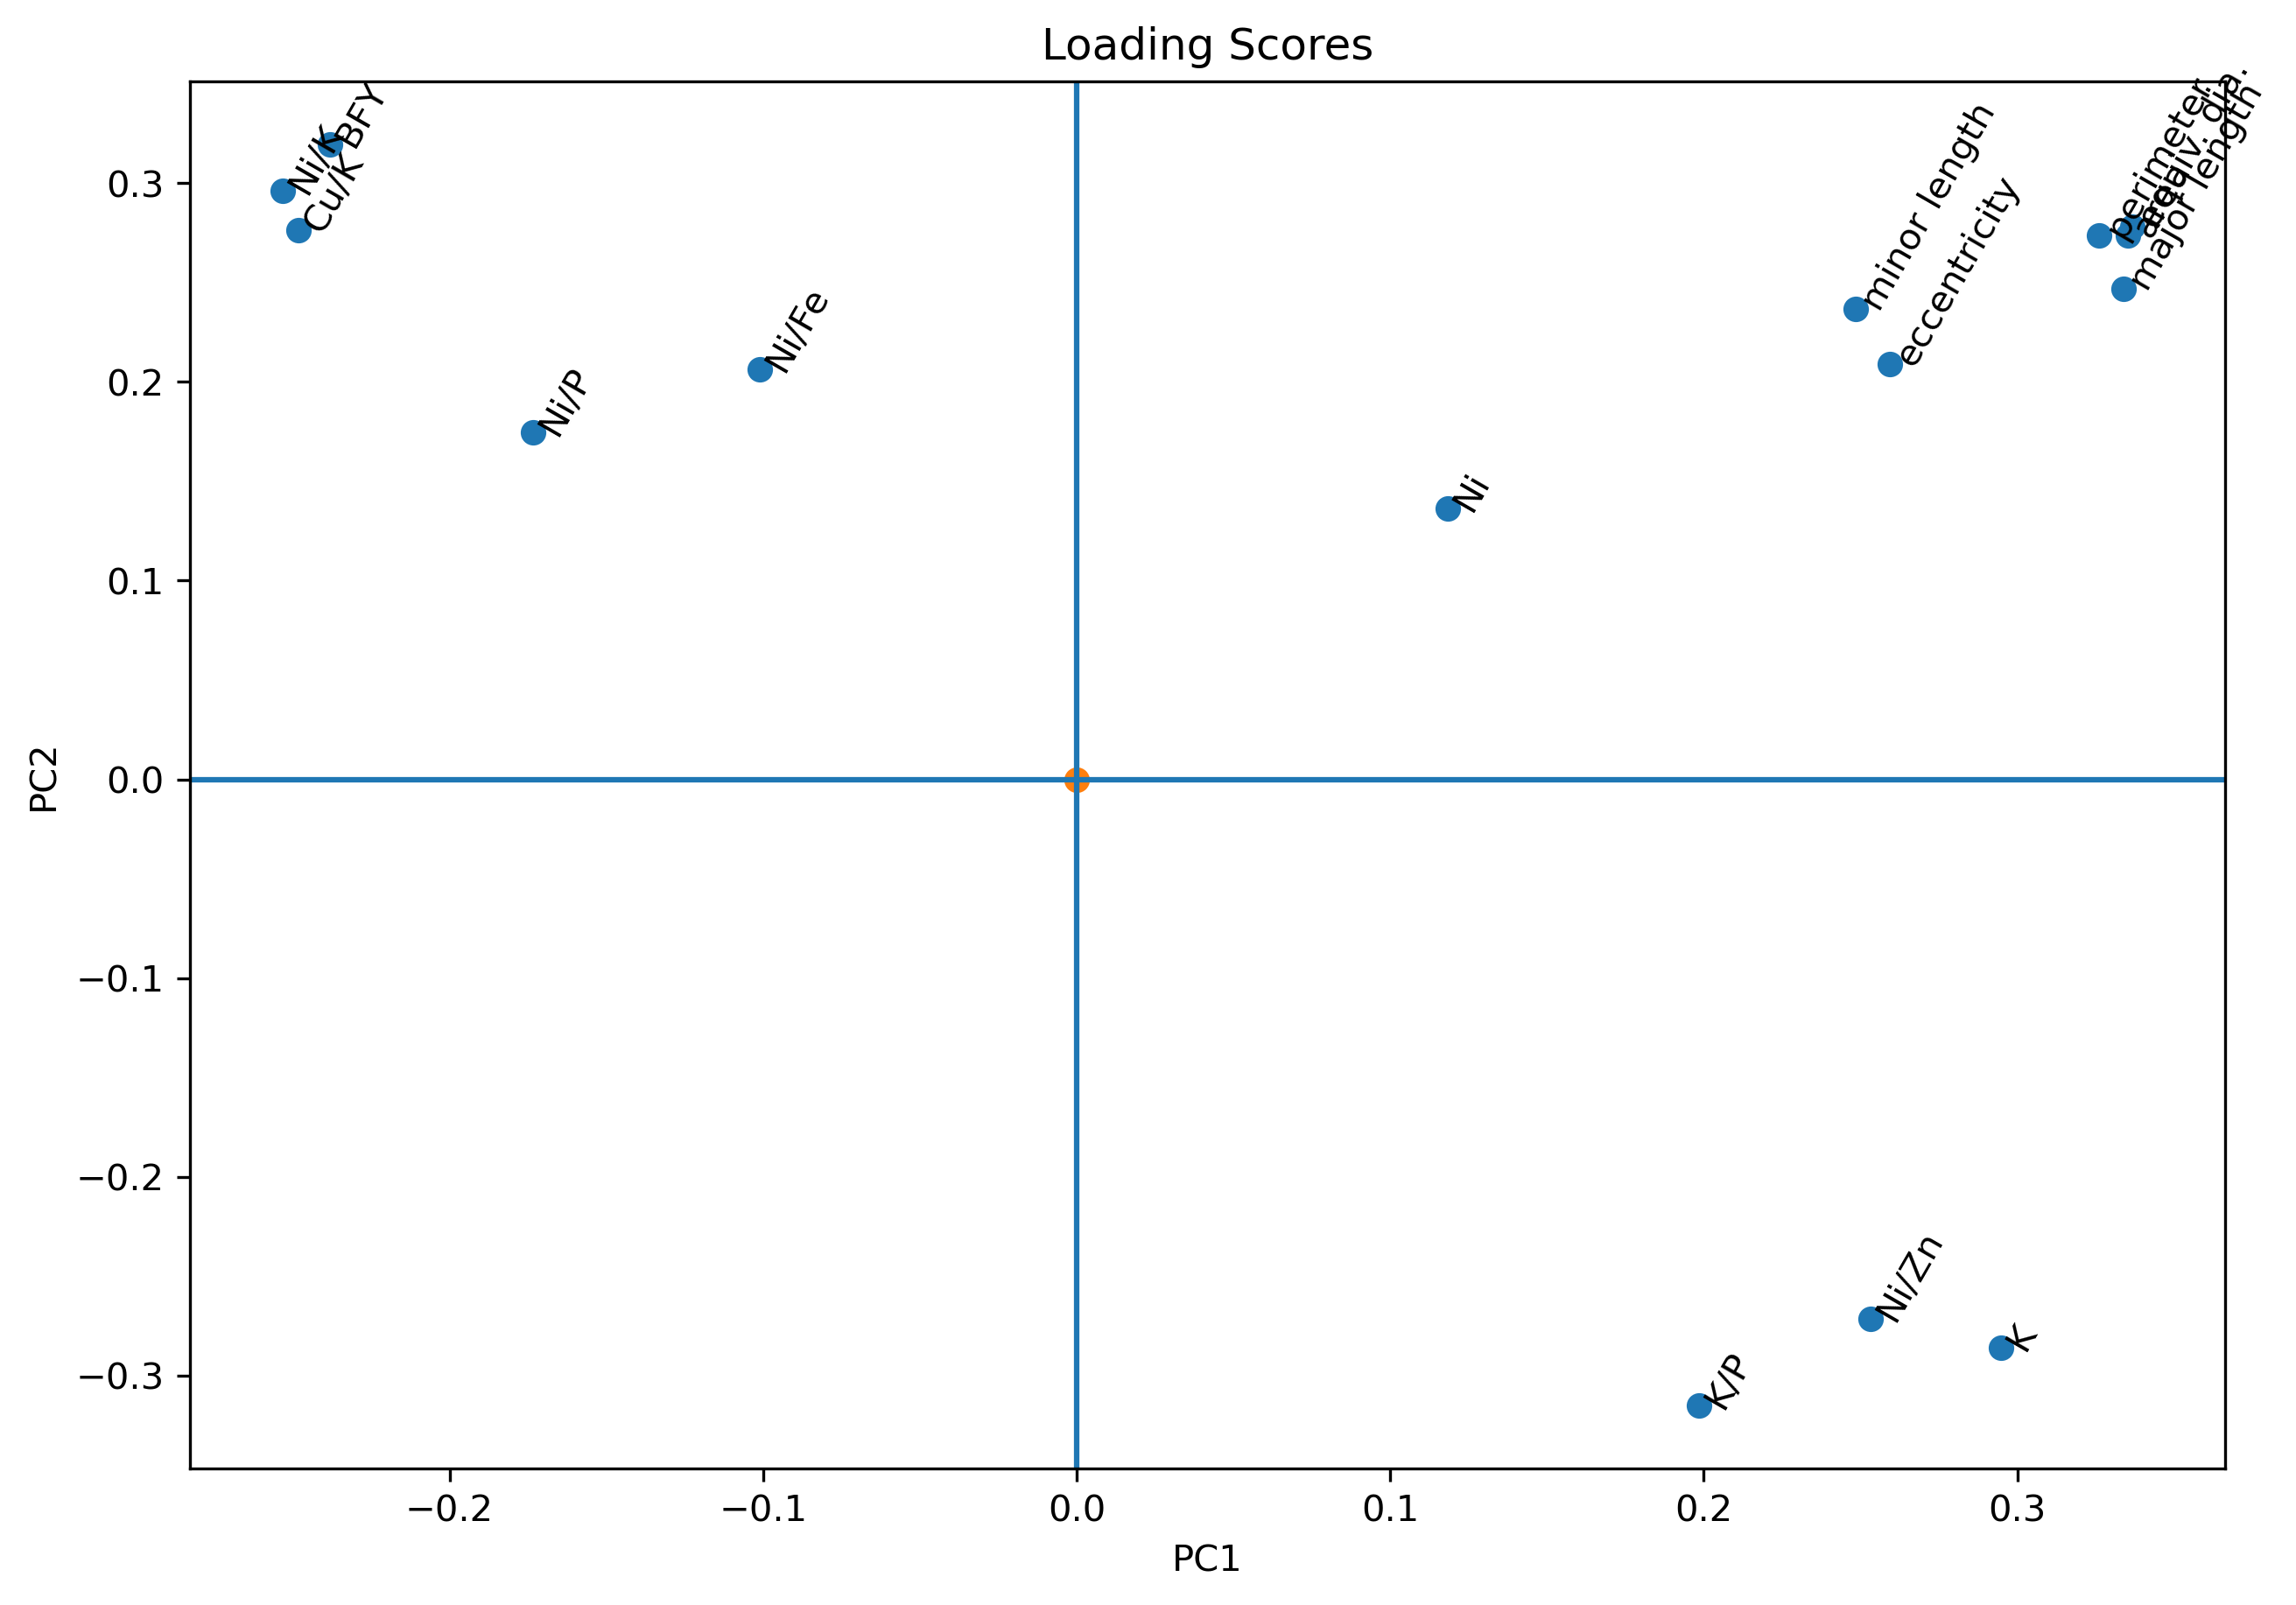

In [24]:
fig = plt.figure(figsize=(10,7),dpi=300);

plt.scatter(pca.components_[0],pca.components_[1]) #, tick_label=PClabels
plt.title('Loading Scores')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axhline()
plt.axvline()

names = ['area','eccentricity','equiv. dia.','major length','minor length','perimeter',
        'K','K/P','Ni','Ni/P','Ni/Zn','Ni/Fe',
         'Ni/K','Cu/K', 'BFY']

for i, txt in enumerate(names):
    plt.annotate(txt, (pca.components_[0][i], pca.components_[1][i]), rotation=60, size=10)

plt.scatter(0,0)
plt.show()


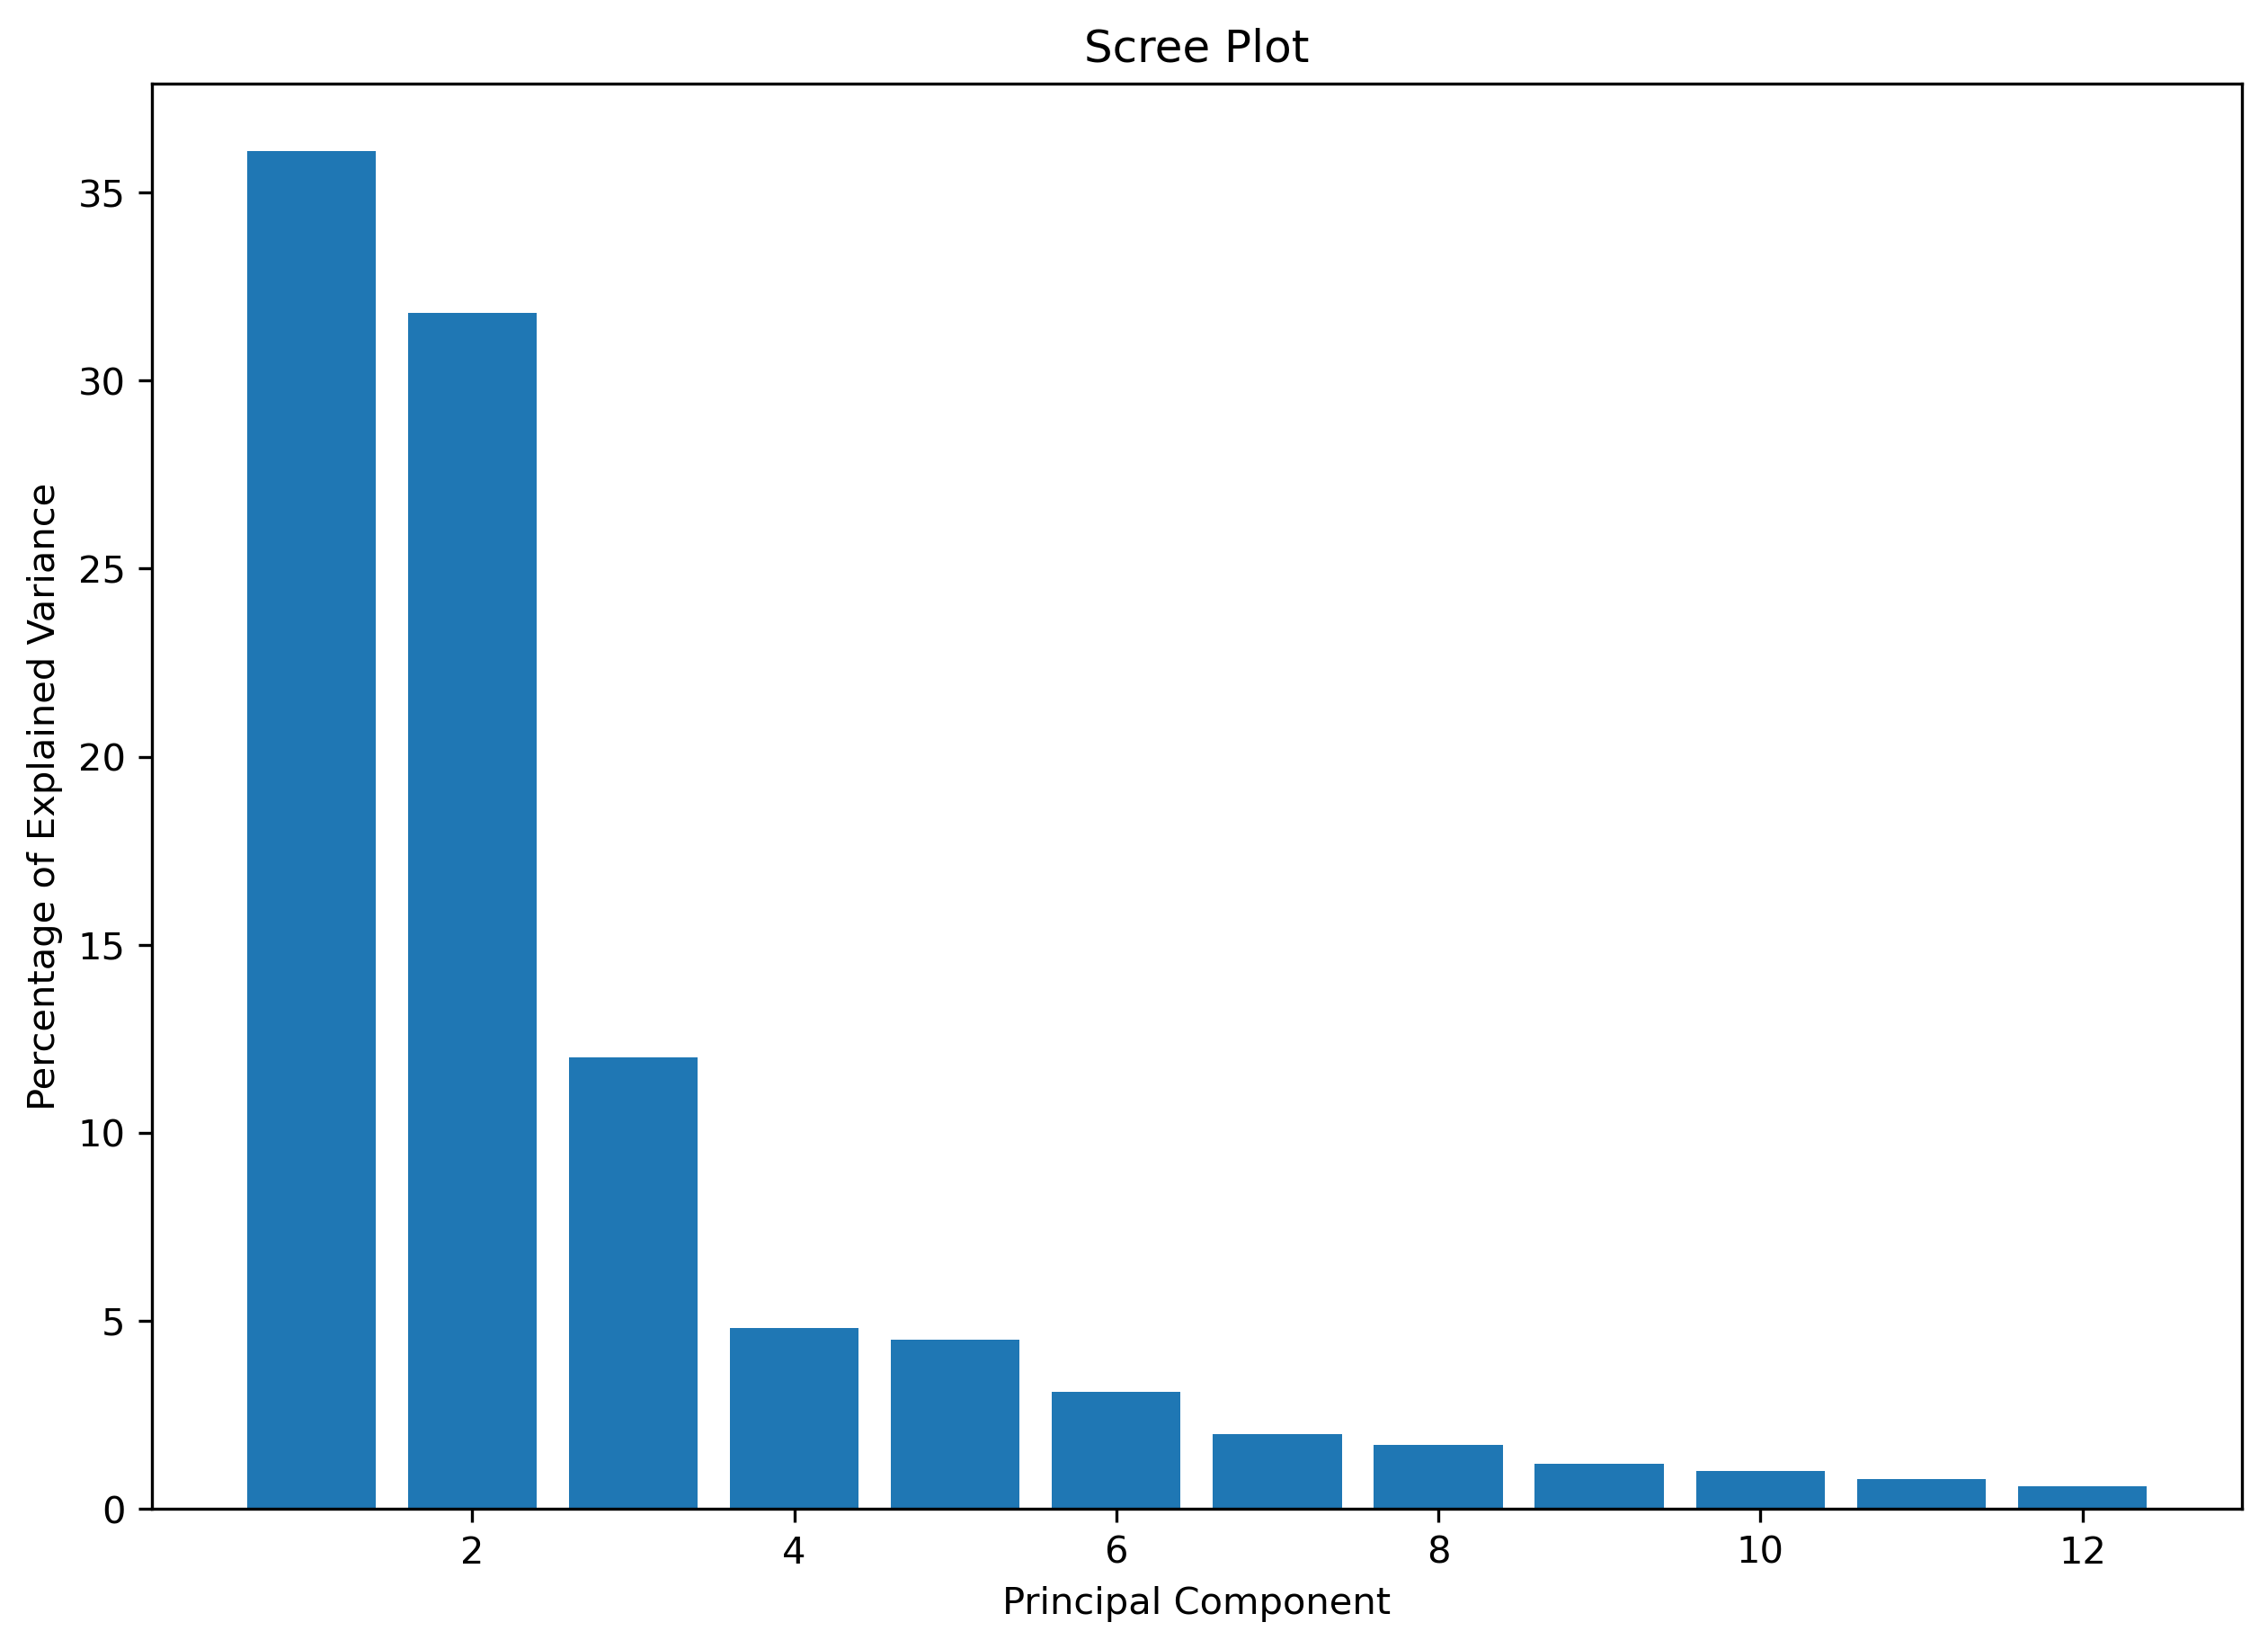

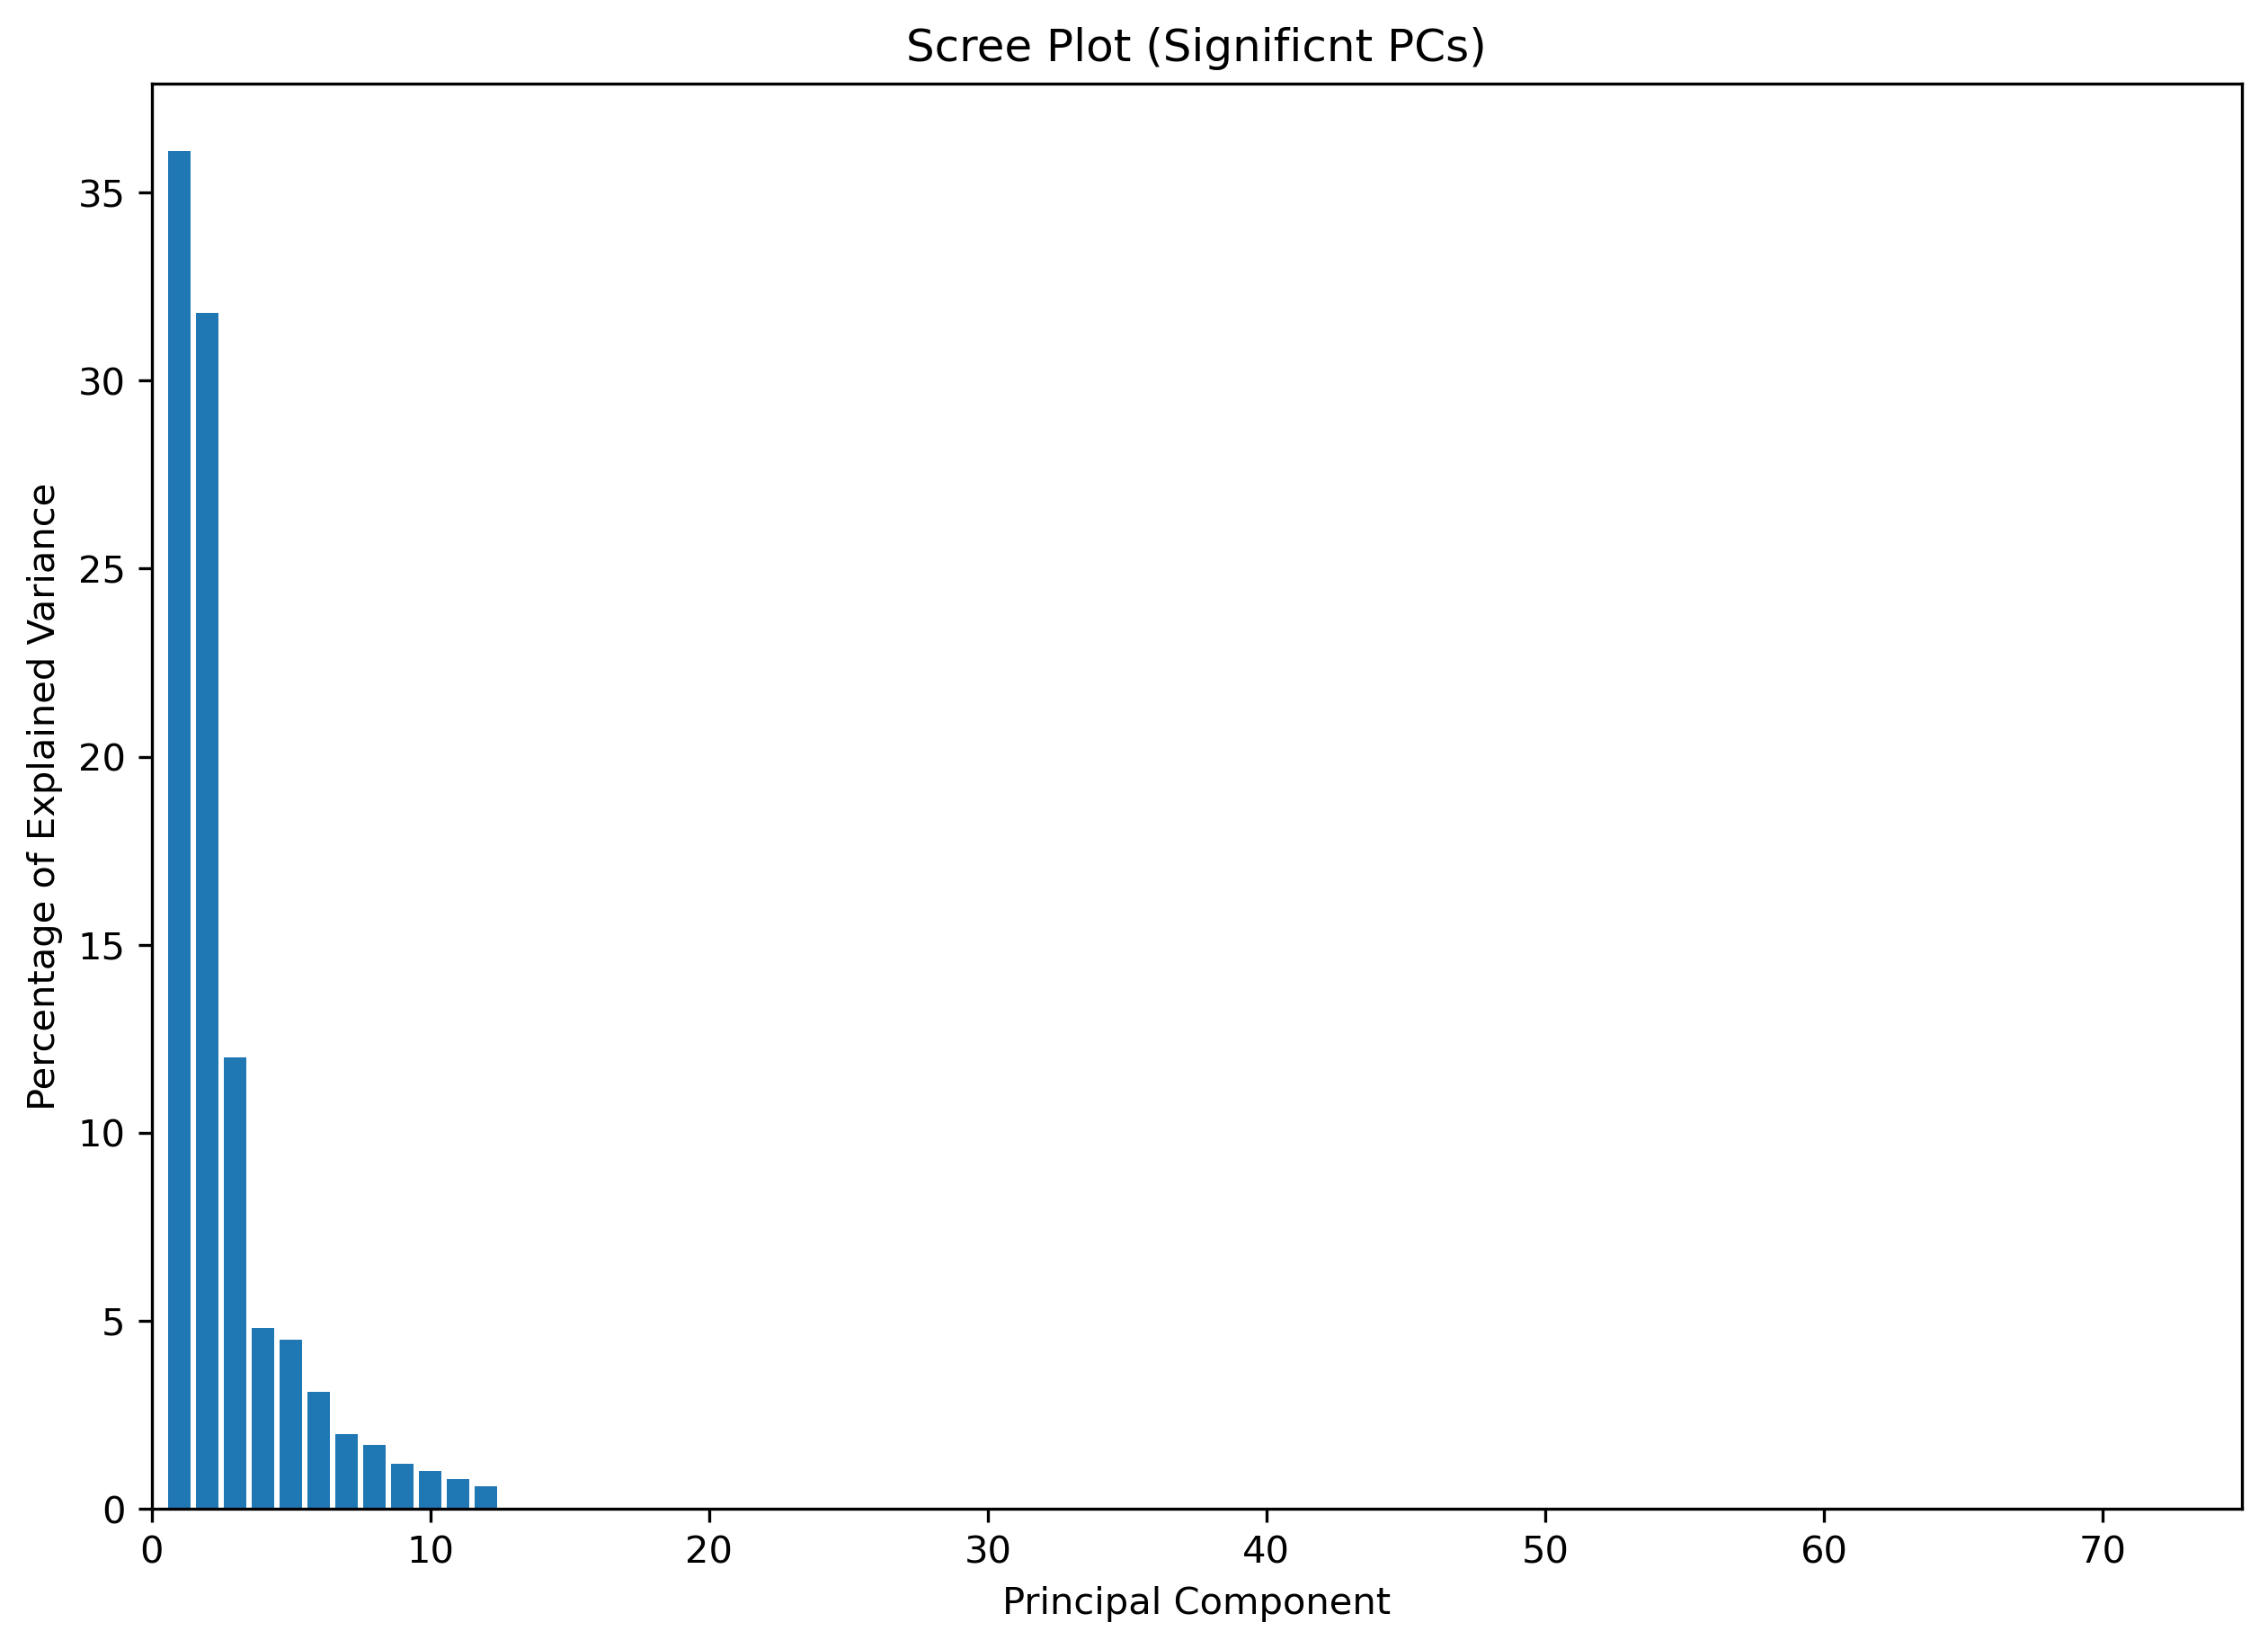

In [25]:
# get scree plot

high_pca = PCA(n_components=12)
high_pca.fit_transform(X_standard)

#calculate percentage of variation in each principal components
per_var=np.round(high_pca.explained_variance_ratio_*100, decimals=1)
PClabels =['PC' + str(x) for x in range(1,len(per_var)+1)]

fig = plt.figure(figsize=(10,7),dpi=300);
plt.bar(x=range(1, len(per_var)+1),height=per_var) #, tick_label=PClabels
plt.title('Scree Plot')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.show()
#zoom in on the important PCs
fig = plt.figure(figsize=(10,7),dpi=300);
plt.bar(x=range(1, len(per_var)+1),height=per_var) #, tick_label=PClabels
plt.title('Scree Plot (Significnt PCs)')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.xlim(0,75)
plt.show()

In [26]:
principalDf['area'] = X[:,0]
principalDf['eccentricity'] = X[:,1]
principalDf['equivalent_diameter'] = X[:,2]
principalDf['major_axis_length'] = X[:,3]
principalDf['minor_axis_length'] = X[:,4]
principalDf['perimeter'] = X[:,5]
principalDf['K'] = X[:,6]
principalDf['K/P'] = X[:,7]
principalDf['Ni'] = X[:,8]
principalDf['Ni/P'] = X[:,9]
principalDf['Ni/Zn'] = X[:,10]
principalDf['Ni/Fe'] = X[:,11]
principalDf['Ni/K'] = X[:,12]
principalDf['Cu/K'] = X[:,13]
principalDf['BFY'] = X[:,14]

In [27]:
print(principalDf['area'].max())
print(principalDf['eccentricity'].max()) 
print(principalDf['equivalent_diameter'].max())
print(principalDf['major_axis_length'].max()) 
print(principalDf['minor_axis_length'].max()) 
print(principalDf['perimeter'].max()) 
print(principalDf['K'].max()) 
print(principalDf['K/P'].max()) 
print(principalDf['Ni'].max()) 
print(principalDf['Ni/P'].max())
print(principalDf['Ni/Zn'].max())
print(principalDf['Ni/Fe'].max())
print(principalDf['Ni/K'].max())
print(principalDf['Cu/K'].max()) 
print(principalDf['BFY'].max()) 

4.125
0.9769395940802652
2.2917489221187703
4.373612352851659
2.4812696957111178
10.321067811865476
0.0008107276516966522
13.322492599487305
0.00012132191477576271
3.428638458251953
1.6828488111495972
2.031073808670044
4.388086795806885
146.30764770507812
0.025497127324342728


In [28]:
print(principalDf['area'].median())
print(principalDf['eccentricity'].median()) 
print(principalDf['equivalent_diameter'].median())
print(principalDf['major_axis_length'].median()) 
print(principalDf['minor_axis_length'].median()) 
print(principalDf['perimeter'].median()) 
print(principalDf['K'].median()) 
print(principalDf['K/P'].median()) 
print(principalDf['Ni'].median()) 
print(principalDf['Ni/P'].median())
print(principalDf['Ni/Zn'].median())
print(principalDf['Ni/Fe'].median())
print(principalDf['Ni/K'].median())
print(principalDf['Cu/K'].median()) 
print(principalDf['BFY'].median())

0.6875
0.7559289460184544
0.9356025796273888
1.1281521496355325
0.7371064447728443
2.414213562373095
4.2070010749739595e-05
1.1155935525894165
4.0804767195368186e-05
0.9645305275917053
0.04385962337255478
0.6382034420967102
0.9738719761371613
26.046876907348633
0.014730277471244335


In [29]:
principalDf

,PC1,PC2,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,K/P,Ni,Ni/P,Ni/Zn,Ni/Fe,Ni/K,Cu/K,BFY
0,-2.774272,-1.265931,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000029,0.952824,0.000029,0.954267,0.028558,0.405042,1.001515,35.068970,0.015261
1,-3.010857,-0.664700,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000029,0.971523,0.000043,1.457102,0.056597,0.695318,1.499813,26.500006,0.015804
2,-3.051112,-0.648040,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000030,0.662167,0.000043,0.945927,0.039203,0.452991,1.428533,36.439644,0.018326
3,1.385500,2.957820,1.3125,0.846038,1.292721,1.764861,0.940886,3.828427,0.000045,0.536909,0.000058,0.692463,0.041986,0.974724,1.289723,30.718239,0.016610
4,0.383739,1.931101,1.0625,0.945978,1.163107,2.102629,0.681738,2.267767,0.000045,1.085488,0.000055,1.351316,0.054387,0.732575,1.244893,22.889378,0.017689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,6.052691,-0.593279,1.5625,0.941817,1.410474,2.474690,0.831810,5.035534,0.000437,3.567846,0.000056,0.460403,0.948419,0.594451,0.129042,0.136061,0.005319
550,14.052203,6.863220,4.1250,0.780748,2.291749,3.971010,2.481270,10.321068,0.000446,3.038787,0.000066,0.450156,0.670883,0.528698,0.148137,0.220808,0.005296
551,2.533360,-3.242345,0.6875,0.819334,0.935603,1.241999,0.712058,2.267767,0.000449,4.389382,0.000034,0.335201,0.536903,0.502415,0.076366,0.142235,0.004942
552,0.544651,-5.122967,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000313,3.086301,0.000029,0.286142,0.938895,0.249982,0.092714,0.098747,0.004839


<AxesSubplot:>

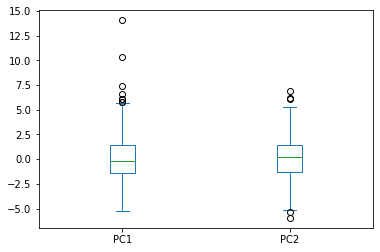

In [30]:
principalDf[['PC1','PC2']].plot.box()

<AxesSubplot:>

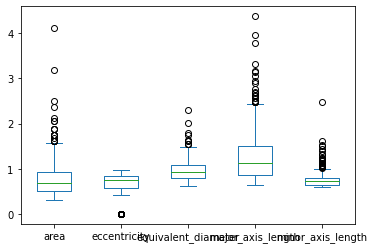

In [31]:
principalDf[['area','eccentricity', 'equivalent_diameter','major_axis_length','minor_axis_length']].plot.box()

<AxesSubplot:>

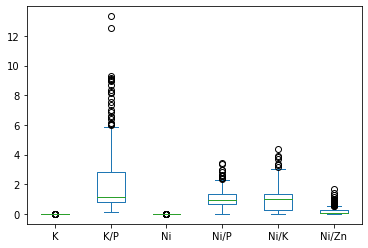

In [32]:
principalDf[['K','K/P', 'Ni','Ni/P','Ni/K','Ni/Zn']].plot.box()

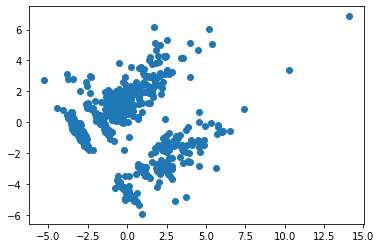

In [33]:
plt.scatter(principalDf['PC1'],principalDf['PC2'])

In [34]:
#Now assign labels based on group 1


In [35]:

# True_list = principalDf[principalDf['equivalent_diameter'] > 3.75].index.tolist()

# the length criterion

# True_list = principalDf.loc[
#     (principalDf['major_axis_length']>=1) & 
#     (principalDf['major_axis_length']<= 3) 
#    ].index.tolist()

# the width criterion

# True_list = principalDf.loc[
#     (principalDf['minor_axis_length']>=0.5) & 
#     (principalDf['minor_axis_length']<= 1.5) 
#    ].index.tolist()

# the eccentricity criterion

# True_list = principalDf.loc[
#     (principalDf['eccentricity'] >= 0.5) &
#     (principalDf['eccentricity'] <= 0.6) &
#     (principalDf['major_axis_length']<= 0.875)
#    ].index.tolist()

# True_list = principalDf.loc[
#     (principalDf['eccentricity'] == 0)
#    ].index.tolist()



# Group 1
# True_list = principalDf.loc[
#     (principalDf['major_axis_length']>=1) & 
#     (principalDf['major_axis_length']<= 3) &
#     (principalDf['minor_axis_length']>=0.5) & 
#     (principalDf['minor_axis_length']<= 1.5) 
    
#    ].index.tolist()

# Group 2 (live)
# K_threshold=4.2e-05 #default is median
# KbyP_threshold=1 #default is median
# True_list = principalDf.loc[
#     (principalDf['major_axis_length']>=1) & 
#     (principalDf['major_axis_length']<= 3) &
#     (principalDf['minor_axis_length']>=0.5) & 
#     (principalDf['minor_axis_length']<= 1.5) &
#     (principalDf['K']>=K_threshold) &
#     (principalDf['K/P']>= KbyP_threshold)
#    ].index.tolist()

# Group 3 (Dead)
Ni_threshold=2.04e-05 #default is half of median
NibyP_threshold=0.48 #default is half of median

NibyZn_threshold=0.021 #default is half of median
NibyFe_threshold=0.32 #default is half of median
NibyK_threshold=0.485 #default is half of median
CubyK_threshold=13 #default is half of median

True_list = principalDf.loc[
    (principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) &
    (principalDf['Ni']>=Ni_threshold) &
    (principalDf['Ni/P']>= NibyP_threshold) &
    (principalDf['Ni/Zn']>= NibyZn_threshold) &
    (principalDf['Ni/Fe']>= NibyFe_threshold) &
    (principalDf['Ni/K']>= NibyK_threshold) &
    (principalDf['Cu/K']>= CubyK_threshold)
   ].index.tolist()


# Group 3' (Low Ni cells)
# Ni_threshold=2.04e-05 #default is half of median
# NibyP_threshold=0.48 #default is half of median

# NibyZn_threshold=0.021 #default is half of median
# NibyFe_threshold=0.32 #default is half of median
# NibyK_threshold=0.485 #default is half of median
# CubyK_threshold=13 #default is half of median

# True_list = principalDf.loc[
#     (principalDf['major_axis_length']>=1) & 
#     (principalDf['major_axis_length']<= 3) &
#     (principalDf['minor_axis_length']>=0.5) & 
#     (principalDf['minor_axis_length']<= 1.5) &
#     ((principalDf['Ni']<=Ni_threshold) |
#     (principalDf['Ni/P']<= NibyP_threshold) |
#     (principalDf['Ni/Zn']<= NibyZn_threshold) |
#     (principalDf['Ni/Fe']<= NibyFe_threshold) |
#     (principalDf['Ni/K']<= NibyK_threshold) |
#     (principalDf['Cu/K']<= CubyK_threshold))
#    ].index.tolist()

# Area criterion (identifies some of the oultiers on the right extereme)
# True_list = principalDf.loc[
#     (principalDf['area'] >= 2)
#    ].index.tolist()



In [36]:
#create dataframe for group 1
DF_group1=principalDf.loc[
    (principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) 
    
   ]

In [37]:
# True_list

In [38]:
len(True_list)

220

In [39]:
#view cells from the True_list

def viewer(idx):
    plt.imshow(X_bin[True_list[idx]], cmap='gnuplot2');

    
    plt.title(True_list[idx])
    plt.colorbar()
#     plt.ylim(-0.5, 5)
#     plt.grid(True)
    plt.show()

interactive_plot = interactive(viewer, idx=(0, len(True_list)-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=109, description='idx', max=219), Output()), _dom_classes=('widget-inter…

In [40]:
labels=np.zeros(X.shape[0])
labels.shape
for idx in True_list:
    labels[idx]=1
principalDf['labels'] = labels.astype('bool')

In [41]:
# principalDf

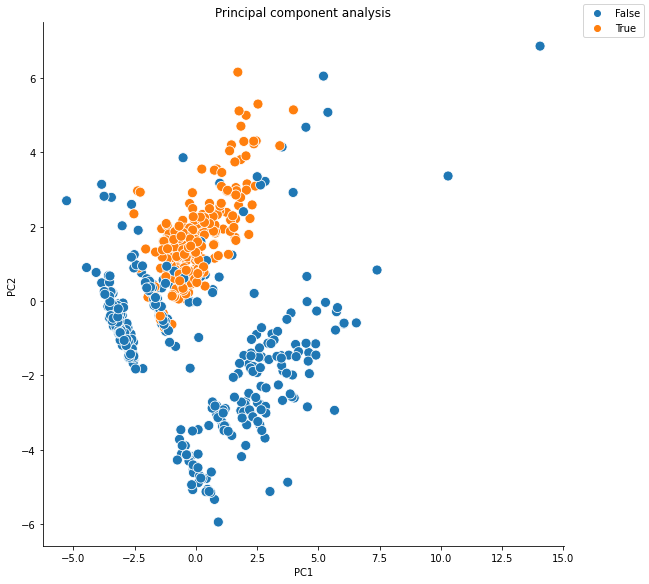

In [42]:
#with histogram

# pp = sns.pairplot(principalDf[['PC1','PC2', 'labels']], kind = 'scatter', 
#                  diag_kind='hist', corner = 'True', hue = 'labels', height=4)

# pp = sns.pairplot(data=principalDf,
#                   y_vars=['PC2'],
#                   x_vars=['PC1'],
#                   kind = 'scatter', 
#                  diag_kind='hist', corner = 'True', hue='labels', height=8
#                  )

pp = sns.pairplot(data=principalDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='labels', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis')



In [43]:
# now create mult label data frame with strict conditions

labels = [0] * X.shape[0]


# the artifact criterion Group 0

True_list = principalDf.loc[
    (principalDf['eccentricity'] == 0)
    
   ].index.tolist()

print( len(True_list) )

for idx in True_list:
    labels[idx]='Group 0: Artifact, e = 0'

# Group 1
True_list = principalDf.loc[
    (principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) 
    
   ].index.tolist()
print( len(True_list) )

for idx in True_list:
    labels[idx]='Group 1: Only Shape'
    
# Group 2 (live)
K_threshold=4.2e-05 #default is median
KbyP_threshold=1 #default is median
True_list = principalDf.loc[
    (principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) &
    (principalDf['K']>=K_threshold) &
    (principalDf['K/P']>= KbyP_threshold)
   ].index.tolist()

print( len(True_list) )

for idx in True_list:
    labels[idx]='Group 2: Shape + Live'
    
# Group 3 (Dead)
Ni_threshold=2.04e-05 #default is half of median
NibyP_threshold=0.48 #default is half of median

NibyZn_threshold=0.021 #default is half of median
NibyFe_threshold=0.32 #default is half of median
NibyK_threshold=0.485 #default is half of median
CubyK_threshold=13 #default is half of median

True_list = principalDf.loc[
    (principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) &
    (principalDf['Ni']>=Ni_threshold) &
    (principalDf['Ni/P']>= NibyP_threshold) &
    (principalDf['Ni/Zn']>= NibyZn_threshold) &
    (principalDf['Ni/Fe']>= NibyFe_threshold) &
    (principalDf['Ni/K']>= NibyK_threshold) &
    (principalDf['Cu/K']>= CubyK_threshold)
   ].index.tolist()    
    
print( len(True_list) )

for idx in True_list:
    labels[idx]='Group 3: Shape + Dead' 
    

    
    
# the eccentricity criterion

True_list = principalDf.loc[
    (principalDf['eccentricity'] >= 0.5) &
    (principalDf['eccentricity'] <= 0.6) &
    (principalDf['major_axis_length']<= 0.875)
   ].index.tolist()

print( len(True_list) )

for idx in True_list:
    labels[idx]='Group 4: 0.5 <= e <=0.6, l<=0.975'
    

for idx in range(len(labels)):
    if labels[idx] ==0:
        labels[idx] = 'Group 5: outlier/undetermined'
    
principalDf['text_labels'] = labels


132
337
147
220
76


In [44]:
labels

['Group 0: Artifact, e = 0',
 'Group 0: Artifact, e = 0',
 'Group 0: Artifact, e = 0',
 'Group 3: Shape + Dead',
 'Group 3: Shape + Dead',
 'Group 0: Artifact, e = 0',
 'Group 3: Shape + Dead',
 'Group 4: 0.5 <= e <=0.6, l<=0.975',
 'Group 1: Only Shape',
 'Group 3: Shape + Dead',
 'Group 0: Artifact, e = 0',
 'Group 3: Shape + Dead',
 'Group 1: Only Shape',
 'Group 3: Shape + Dead',
 'Group 5: outlier/undetermined',
 'Group 3: Shape + Dead',
 'Group 0: Artifact, e = 0',
 'Group 3: Shape + Dead',
 'Group 3: Shape + Dead',
 'Group 3: Shape + Dead',
 'Group 3: Shape + Dead',
 'Group 3: Shape + Dead',
 'Group 4: 0.5 <= e <=0.6, l<=0.975',
 'Group 3: Shape + Dead',
 'Group 0: Artifact, e = 0',
 'Group 3: Shape + Dead',
 'Group 3: Shape + Dead',
 'Group 3: Shape + Dead',
 'Group 3: Shape + Dead',
 'Group 0: Artifact, e = 0',
 'Group 0: Artifact, e = 0',
 'Group 4: 0.5 <= e <=0.6, l<=0.975',
 'Group 3: Shape + Dead',
 'Group 0: Artifact, e = 0',
 'Group 0: Artifact, e = 0',
 'Group 0: Artifa

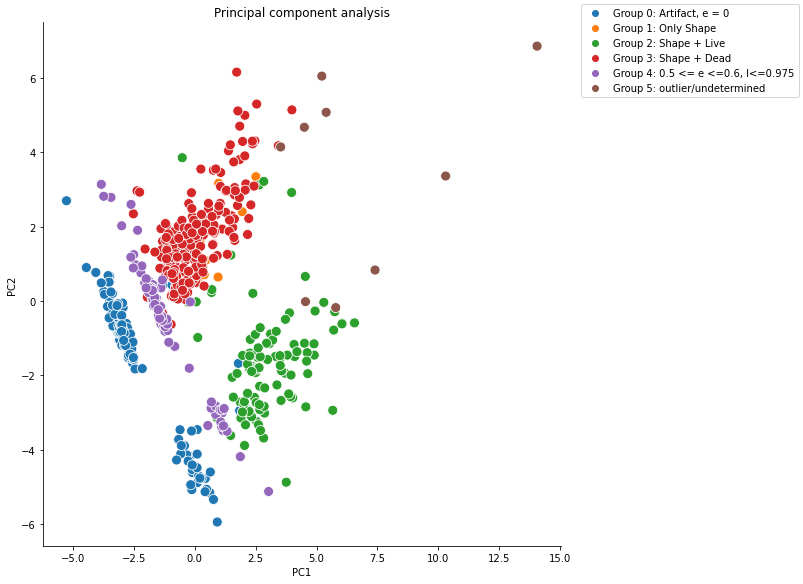

In [45]:
pp = sns.pairplot(data=principalDf.sort_values(by = 'text_labels'),
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis')



In [46]:
# make only 3 groups Group 0: Artifacts/outliers

In [48]:
y=np.zeros(X.shape[0])

In [49]:
# now create mult label data frame with strict conditions

labels = [0] * X.shape[0]


# the artifact criterion Group 0

True_list = principalDf.loc[
    (principalDf['eccentricity'] == 0)
    
   ].index.tolist()

print( len(True_list) )

for idx in True_list:
    labels[idx]='artifacts/background/outlier'

# Group 1
True_list = principalDf.loc[
    (principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) 
    
   ].index.tolist()
print( len(True_list) )

for idx in True_list:
    labels[idx]='artifacts/background/outlier'
    
# Group 2 (live)
K_threshold=4.2e-05 #default is median
KbyP_threshold=1 #default is median
True_list = principalDf.loc[
    (principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) &
    (principalDf['K']>=K_threshold) &
    (principalDf['K/P']>= KbyP_threshold)
   ].index.tolist()

print( len(True_list) )

for idx in True_list:
    labels[idx]='live cells'
    y[idx]=1
    
# Group 3 (Dead)
Ni_threshold=2.04e-05 #default is half of median
NibyP_threshold=0.48 #default is half of median

NibyZn_threshold=0.021 #default is half of median
NibyFe_threshold=0.32 #default is half of median
NibyK_threshold=0.485 #default is half of median
CubyK_threshold=13 #default is half of median

True_list = principalDf.loc[
    (principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) &
    (principalDf['Ni']>=Ni_threshold) &
    (principalDf['Ni/P']>= NibyP_threshold) &
    (principalDf['Ni/Zn']>= NibyZn_threshold) &
    (principalDf['Ni/Fe']>= NibyFe_threshold) &
    (principalDf['Ni/K']>= NibyK_threshold) &
    (principalDf['Cu/K']>= CubyK_threshold)
   ].index.tolist()    
    
print( len(True_list) )

for idx in True_list:
    labels[idx]='dead cells'
    y[idx]=2
    

    
    
# the eccentricity criterion

True_list = principalDf.loc[
    (principalDf['eccentricity'] >= 0.5) &
    (principalDf['eccentricity'] <= 0.6) &
    (principalDf['major_axis_length']<= 0.875)
   ].index.tolist()

print( len(True_list) )

for idx in True_list:
    labels[idx]='artifacts/background/outlier'
    

for idx in range(len(labels)):
    if labels[idx] ==0:
        labels[idx]='artifacts/background/outlier'
    
principalDf['text_labels'] = labels


132
337
147
220
76


In [50]:
y=y.astype(int)

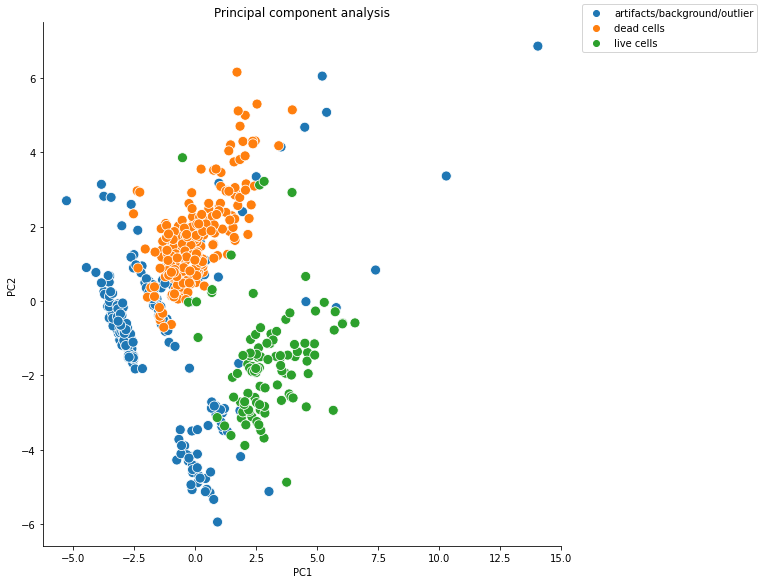

In [51]:
pp = sns.pairplot(data=principalDf.sort_values(by = 'text_labels'),
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis')



In [93]:
# Try soft k-means on this annotated data

In [140]:
# kmeansDF=principalDf.drop(labels=['PC1','PC2'], axis=1)
kmeansDF=principalDf

In [141]:
kmeansDF

,PC1,PC2,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,K/P,...,Ni/K,Cu/K,labels,text_labels,Class,p0,p1,p2,confidence,y
0,-3.006349,0.319806,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000029,0.952824,...,1.001515,35.068970,False,artifacts/background/outlier,0,0.885315,0.114685,0,0.885315,0
1,-3.014873,-0.356706,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000029,0.971523,...,1.499813,26.500006,False,artifacts/background/outlier,0,0.937396,0.062604,0,0.937396,0
2,-2.975985,-0.126997,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000030,0.662167,...,1.428533,36.439644,False,artifacts/background/outlier,0,0.925897,0.074103,0,0.925897,0
3,2.411925,-2.077315,1.3125,0.846038,1.292721,1.764861,0.940886,3.828427,0.000045,0.536909,...,1.289723,30.718239,False,dead cells,0,0.891954,0.108046,0,0.891954,2
4,1.141308,-1.356580,1.0625,0.945978,1.163107,2.102629,0.681738,2.267767,0.000045,1.085488,...,1.244893,22.889378,False,dead cells,0,0.980074,0.019926,0,0.980074,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,5.298707,2.273811,1.5625,0.941817,1.410474,2.474690,0.831810,5.035534,0.000437,3.567846,...,0.129042,0.136061,False,live cells,1,0.136801,0.863199,0,0.863199,1
550,15.431255,-1.858857,4.1250,0.780748,2.291749,3.971010,2.481270,10.321068,0.000446,3.038787,...,0.148137,0.220808,True,artifacts/background/outlier,1,0.445851,0.554149,0,0.554149,0
551,1.054544,3.460564,0.6875,0.819334,0.935603,1.241999,0.712058,2.267767,0.000449,4.389382,...,0.076366,0.142235,False,live cells,1,0.000238,0.999762,0,0.999762,1
552,-1.476497,4.506086,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000313,3.086301,...,0.092714,0.098747,False,artifacts/background/outlier,1,0.080941,0.919059,0,0.919059,0


In [2]:
# part 2 

In [6]:
class XRF_image:
    
    def __init__(self, xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False):
        self.xrf_filename =xrf_filename
        self.BASE_PATCH_WIDTH=BASE_PATCH_WIDTH
        
        
    def load_xrf_data(self, hdf5_string = 'exchange_4'):
#         global d_Cu, d_Zn, d_Ca, d_K, d_P, d_S,d_Fe, d_Ni, d_TFY
    
        norm_ch = NORM_CH
        value_offset=VALUE_OFFSET
        xrfdata = collections.defaultdict(list)

        with h5py.File(self.xrf_filename, 'r') as dat:
            groups= list(dat.keys())
            maps= list(dat['MAPS'].keys())
            chs = dat['MAPS/channel_names'][:].astype(str).tolist()
        #         dat['MAPS/']
        #         print(chs)



            xrf = dat['MAPS/XRF_roi'][:]
        #         print(xrf)

            scaler_names = dat['MAPS/scaler_names'][:].astype(str).tolist()
            scaler_val = dat['MAPS/scalers'][:]
            norm = scaler_val[scaler_names.index(norm_ch)]
            for e in chs:
                chidx = chs.index(e)
                xrfdata[e].append(xrf[chidx]/norm)
            xrfdata['scan_num'].append(self.xrf_filename)

            hdf5_string = hdf5_string

            xrfdata['x_axis'].append(dat[hdf5_string + '/x_axis'][:])
            xrfdata['y_axis'].append(dat[hdf5_string + '/y_axis'][:])

        #         xrfdata['x_axis'].append(dat['exchange_4/x_axis'][:])
        #         xrfdata['y_axis'].append(dat['exchange_4/y_axis'][:])
        xrfdata = pd.DataFrame(xrfdata)
        #     print(xrfdata)

        elms=['Cu','Zn','Ca', 'K', 'P', 'S','Fe','Ni','TFY']#Default elms
        for i, row in xrfdata.iterrows():
                sc = row['scan_num'][0:row['scan_num'].index('.')]
                for e in elms:
                    d = row[e]

                    d[np.isnan(d) | np.isinf(d)] = 0
                    norm_d = (d - np.min(d)) / (np.max(d) - np.min(d)) + value_offset
                    ss = np.round(np.abs(np.diff(row['x_axis']))[0], 2)
                    if e == 'Cu':
                        self.d_Cu=d
                        self.norm_d_Cu=norm_d
                        x_Cu,y_Cu=row['x_axis'], row['y_axis']
                    if e == 'Zn':
                        self.d_Zn=d
                        self.norm_d_Zn=norm_d
                        x_Zn,y_Zn=row['x_axis'], row['y_axis']
                    if e == 'Ca':
                        self.d_Ca=d
                        self.norm_d_Ca=norm_d
                        x_Ca,y_Ca=row['x_axis'], row['y_axis']
                    if e == 'K':
                        self.d_K=d
                        self.norm_d_K=norm_d
                        x_K,y_K=row['x_axis'], row['y_axis']
                    if e == 'P':
                        self.d_P=d
                        self.norm_d_P=norm_d
                        x_P,y_P=row['x_axis'], row['y_axis']
                    if e == 'S':
                        self.d_S=d
                        self.norm_d_S=norm_d
                        x_S,y_S=row['x_axis'], row['y_axis']

                    if e == 'Fe':
                        self.d_Fe=d
                        self.norm_d_Fe=norm_d
                        x_Fe,y_Fe=row['x_axis'], row['y_axis']

                    if e == 'Ni':
                        self.d_Ni=d
                        self.norm_d_Ni=norm_d
                        x_Ni,y_Ni=row['x_axis'], row['y_axis']

                    if e == 'TFY':
                        self.d_TFY=d
                        self.norm_d_TFY=norm_d
                        x_TFY,y_TFY=row['x_axis'], row['y_axis']
        #     print('Image shape: ',d.shape)
        
        
    def binary_conversion(self, e='Cu'):
        #choose elemental channel for conversion
        
        if e == 'Cu':
            data_original = self.d_Cu
            
        if e == 'Zn':
            data_original = self.d_Zn
            
        if e == 'Ca':
            data_original = self.d_Ca
            
        if e == 'K':
            data_original = self.d_K
            
        if e == 'P':
            data_original = self.d_P
            
        if e == 'S':
            data_original = self.d_S
            

        if e == 'Fe':
            data_original = self.d_Fe
            

        if e == 'Ni':
            data_original = self.d_Ni
            
        if e == 'TFY':
            data_original = self.d_TFY
            
#         data_original=d_Cu
        data=data_original
        data = ndimage.median_filter(data, size=3)


        thresh = 1.5*threshold_otsu(data)
        binary = data < thresh
        binary = binary^1


        binary_eroded=ndimage.binary_erosion(binary).astype(binary.dtype)
        binary_dilated=ndimage.binary_dilation(binary).astype(binary.dtype)
        self.binary_ero_dil=ndimage.binary_dilation(binary_eroded).astype(binary_eroded.dtype)
        
        self.labeled_array, self.num_features = label(self.binary_ero_dil)
        
    def extract_cells(self):
        self.regions = measure.regionprops(self.labeled_array)    
        # print(len(regions))

        self.cell_list = []
        self.center_list = []
        self.Patches_Cu = []
        self.Patches_Zn = []
        self.Patches_Ca = []
        self.Patches_K = []
        self.Patches_P = []
        self.Patches_S = []
        self.Patches_Fe = []
        self.Patches_Ni = []
        self.Patches_TFY= []
        self.binary_img=[]
        self.region_vals=[]
        self.features_list = []

        for idx in range(len(self.regions)):
            self.cell_val_bin=self.regions[idx].image

            self.region_vals.append(self.cell_val_bin)
            self.padded_cell = np.pad(self.cell_val_bin, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.cell_list.append(self.padded_cell)
            self.center_list.append([math.floor(self.regions[idx].centroid[0]), math.floor(self.regions[idx].centroid[1])])
        #     regions[idx].bbox

            self.cell_Cu = self.d_Cu[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Zn = self.d_Zn[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Ca = self.d_Ca[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_K = self.d_K[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_P = self.d_P[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_S = self.d_S[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Fe = self.d_Fe[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Ni = self.d_Ni[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_TFY = self.d_TFY[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]

            self.padded_bin = np.pad(self.cell_val_bin, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Cu = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Zn = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Ca = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_K = np.pad(self.cell_K, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_P = np.pad(self.cell_P, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_S = np.pad(self.cell_S, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Fe = np.pad(self.cell_Fe, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Ni = np.pad(self.cell_Ni, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_TFY = np.pad(self.cell_TFY, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))

            self.binary_img.append(self.padded_bin)
            self.Patches_Cu.append(self.padded_Cu)
            self.Patches_Zn.append(self.padded_Zn)
            self.Patches_Ca.append(self.padded_Ca)
            self.Patches_K.append(self.padded_K)
            self.Patches_P.append(self.padded_P)
            self.Patches_S.append(self.padded_S)
            self.Patches_Fe.append(self.padded_Fe)
            self.Patches_Ni.append(self.padded_Ni)
            self.Patches_TFY.append(self.padded_TFY)


            # define feature vector using averages
        #     x = np.asarray([regions[idx].area, 
        #      regions[idx].eccentricity, 
        #      regions[idx].equivalent_diameter, 
        #      regions[idx].major_axis_length,
        #      regions[idx].minor_axis_length,
        #      regions[idx].perimeter,
        #      np.average(Patches_K[idx]),
        #      np.average(Patches_K[idx])/np.average(Patches_P[idx]),
        #      np.average(Patches_Ni[idx]),
        #      np.average(Patches_Ni[idx])/np.average(Patches_P[idx]),
        #     np.average(Patches_Ni[idx])/np.average(Patches_K[idx]),
        #     np.average(Patches_Cu[idx])/np.average(Patches_K[idx]),
        #     ])

            # define feature vector using averages
            self.x = np.asarray([0.25*0.25*self.regions[idx].area, 
             self.regions[idx].eccentricity, 
             0.25*self.regions[idx].equivalent_diameter, 
             0.25*self.regions[idx].major_axis_length,
             0.25*self.regions[idx].minor_axis_length,
             0.25*self.regions[idx].perimeter,
             np.amax(self.Patches_K[idx]),
             np.amax(self.Patches_P[idx]),
             np.amax(self.Patches_Ni[idx]),
             np.amax(self.Patches_Zn[idx]),
            np.amax(self.Patches_Fe[idx]),
            np.amax(self.Patches_Cu[idx]),
            np.amax(self.Patches_TFY[idx]-self.Patches_K[idx]-self.Patches_P[idx]-self.Patches_Ni[idx]-self.Patches_Zn[idx]-self.Patches_Fe[idx]-self.Patches_Cu[idx])                     
            ])

            self.features_list.append(self.x)
        self.features=np.asarray(self.features_list)



In [7]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin1=x.binary_img
X1=x.features
X1.shape

(110, 13)

In [8]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_3.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='K')
x.extract_cells()
X_bin2=x.binary_img
X2=x.features
X2.shape

(41, 13)

In [9]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0003_2018_3.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='K')
x.extract_cells()
X_bin3=x.binary_img
X3=x.features
X3.shape

(43, 13)

In [10]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0012_2018_1w2.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin4=x.binary_img
X4=x.features
X4.shape

(53, 13)

In [11]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0014_2018_1w2.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin5=x.binary_img
X5=x.features
X5.shape

(55, 13)

In [12]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0040_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin6=x.binary_img
X6=x.features
X6.shape

(39, 13)

In [13]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0050_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin7=x.binary_img
X7=x.features
X7.shape

(57, 13)

In [14]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0051_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin8=x.binary_img
X8=x.features
X8.shape

(61, 13)

In [15]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0052_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin9=x.binary_img
X9=x.features
X9.shape

(31, 13)

In [16]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0065_2018_3.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='K')
x.extract_cells()
X_bin10=x.binary_img
X10=x.features
X10.shape

(64, 13)

In [17]:
X=np.concatenate((X1,X2,X3,X4,X5,X6,X7,X8,X9,X10))
X_bin=np.concatenate((X_bin1,X_bin2,X_bin3,X_bin4,X_bin5,X_bin6,X_bin7,X_bin8,X_bin9,X_bin10))


In [18]:
print(X.shape)
print(X_bin.shape)

(554, 13)
(554, 32, 32)


In [19]:
def viewer(idx):

    plt.imshow(X_bin[idx]);

    
    plt.title('Binary image')
    plt.colorbar()
#     plt.ylim(-0.5, 5)
#     plt.grid(True)
    plt.show()

interactive_plot = interactive(viewer, idx=(0, len(X_bin)-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=276, description='idx', max=553), Output()), _dom_classes=('widget-inter…

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_standard = StandardScaler().fit_transform(X)

# reduced_X = PCA(=2).fit(X)

In [21]:
print(X_standard[0])

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_standard)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])


print(pca.singular_values_)
print(pca.explained_variance_)
print(pca.components_)

[-1.03765961 -1.69432343 -1.24468001 -1.0746984  -0.79013015 -1.04179638
 -0.61902571 -0.6945955  -0.90463501  0.16871373  0.12428687  0.16871373
  0.42650469]
[54.93414861 43.57970819]
[5.45707176 3.43434171]
[[ 0.41230348  0.31368405  0.41501348  0.3986508   0.32214264  0.40370669
   0.13477547  0.19699636  0.18549451  0.02271229  0.19272202  0.02271229
  -0.06434953]
 [ 0.07806986  0.06488228  0.08592718  0.04543056  0.10614566  0.08438774
  -0.46915421 -0.27023878  0.0064027   0.43642572 -0.2525177   0.43642572
   0.47326959]]


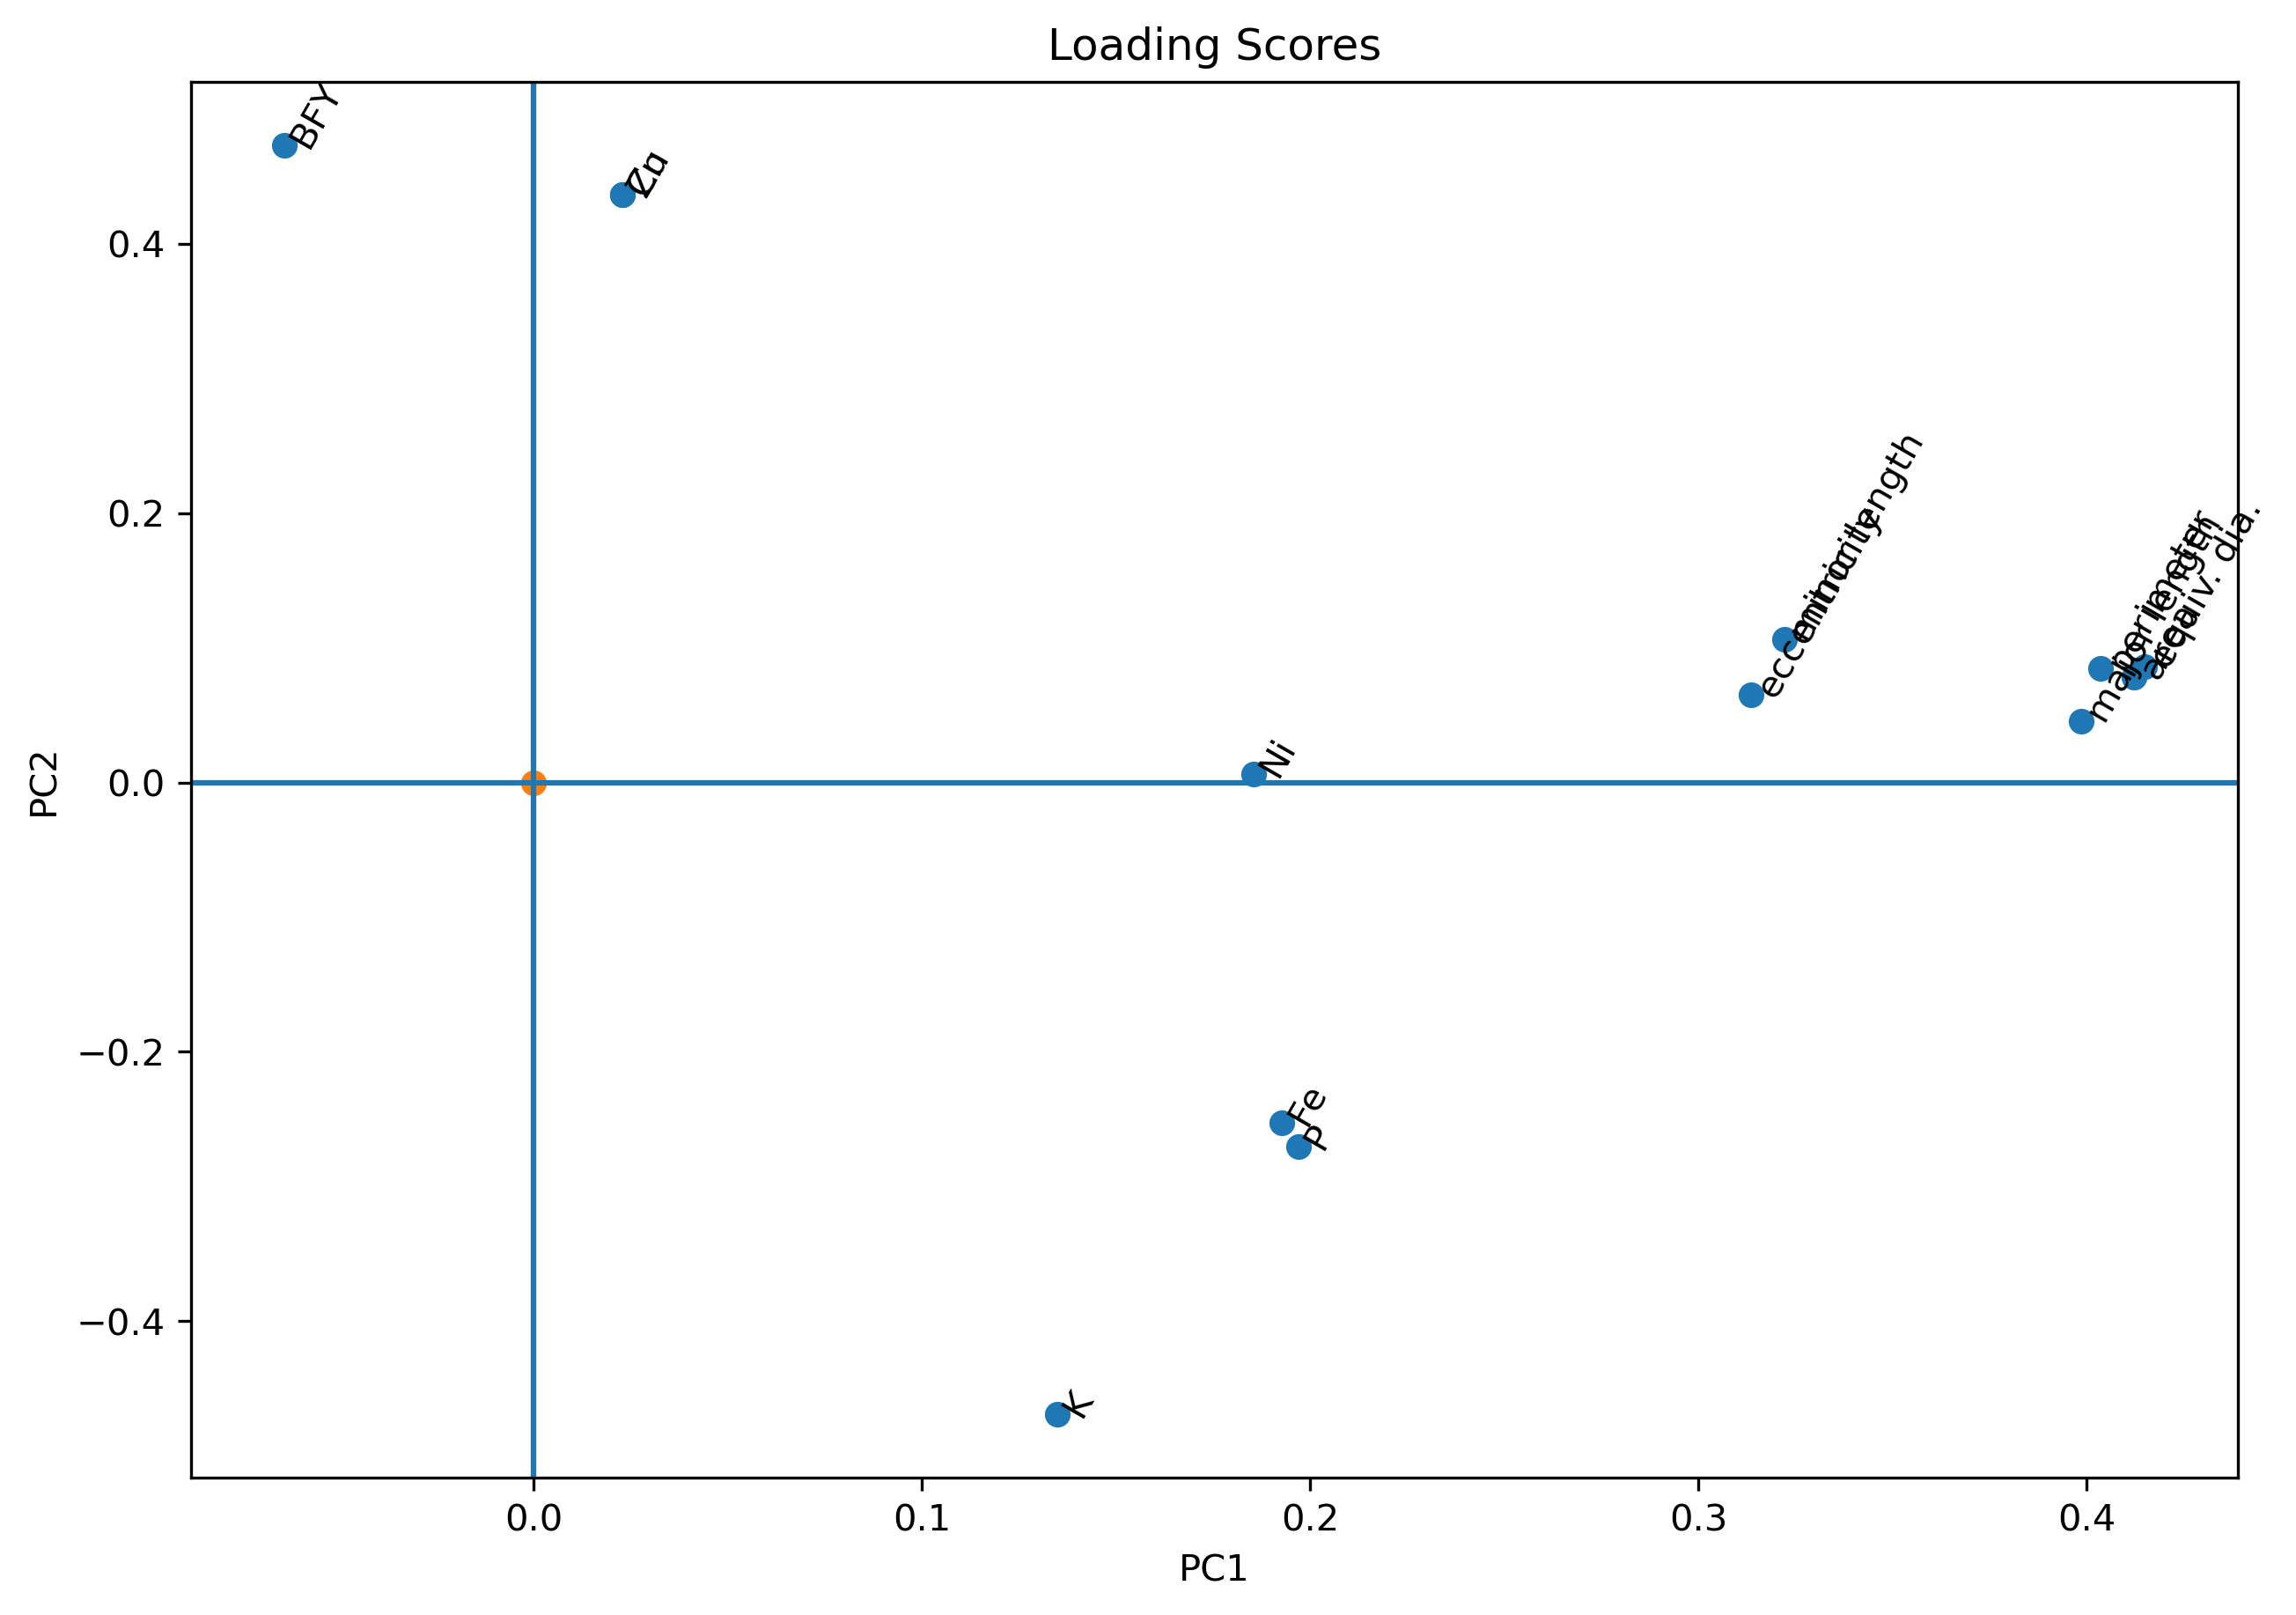

In [22]:
fig = plt.figure(figsize=(10,7),dpi=300);

plt.scatter(pca.components_[0],pca.components_[1]) #, tick_label=PClabels
plt.title('Loading Scores')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axhline()
plt.axvline()

names = ['area','eccentricity','equiv. dia.','major length','minor length','perimeter',
        'K','P','Ni','Zn',
         'Fe','Cu', 'BFY']

for i, txt in enumerate(names):
    plt.annotate(txt, (pca.components_[0][i], pca.components_[1][i]), rotation=60, size=10)

plt.scatter(0,0)
plt.show()


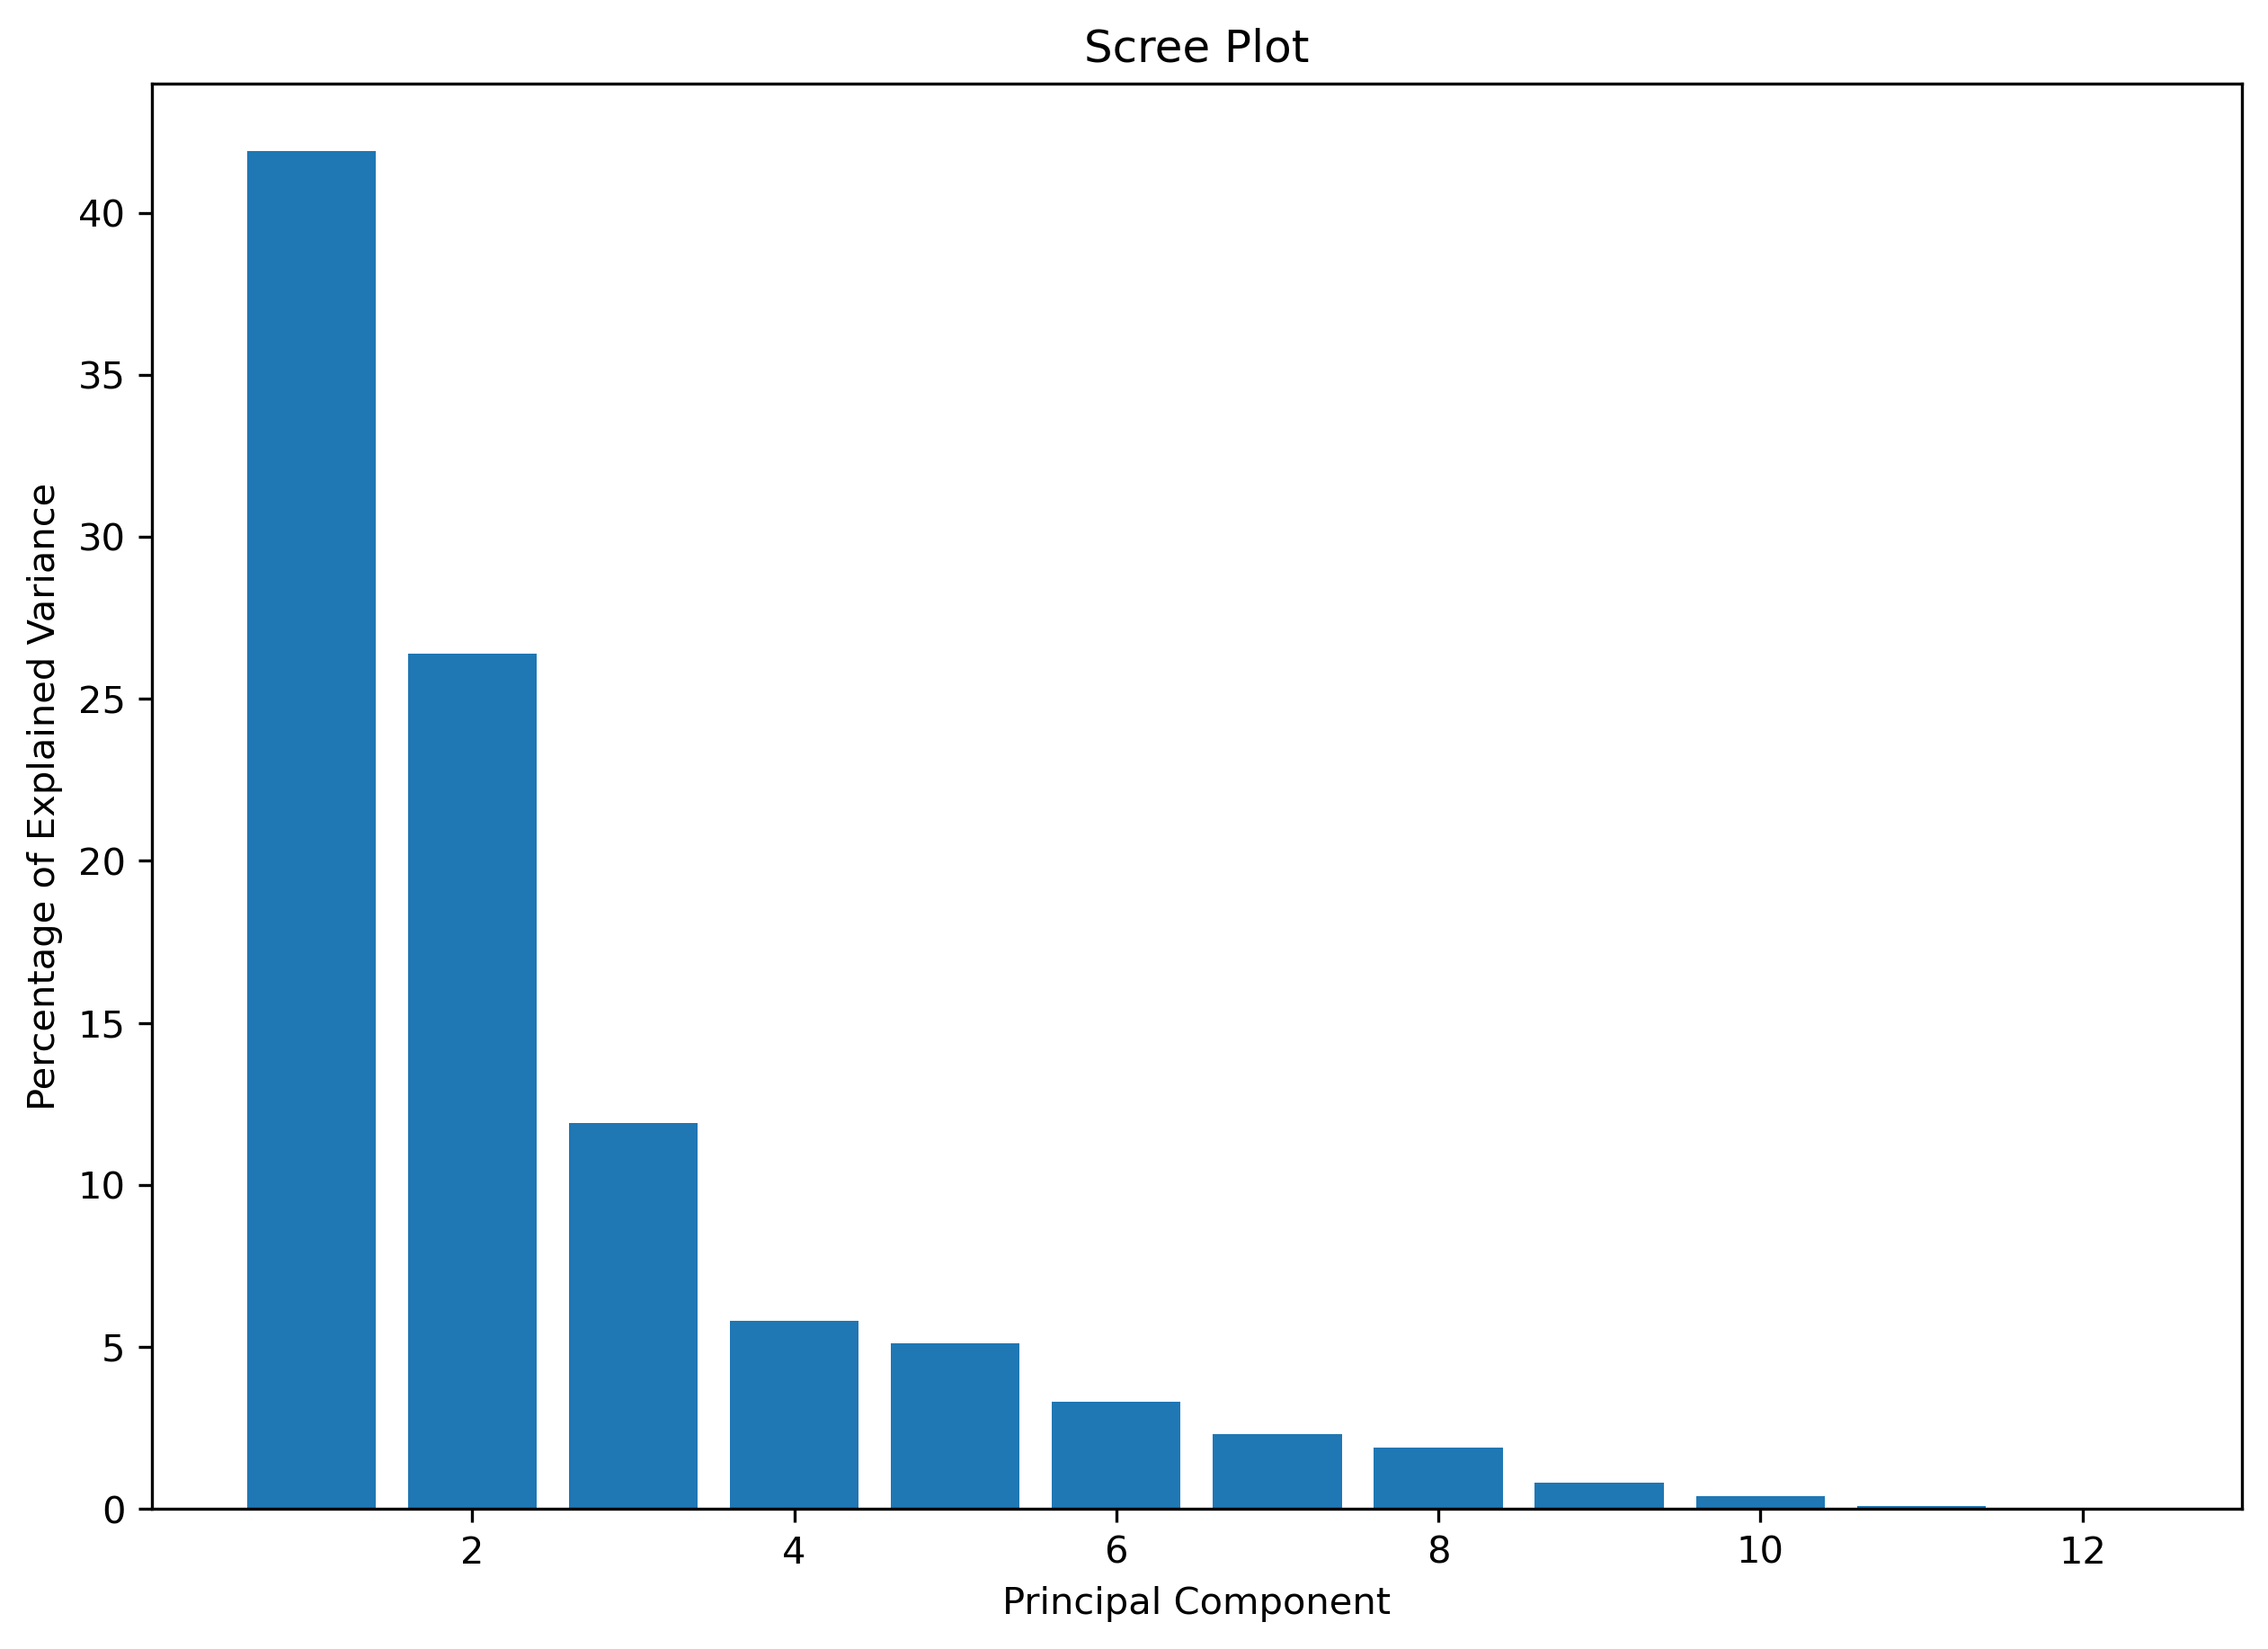

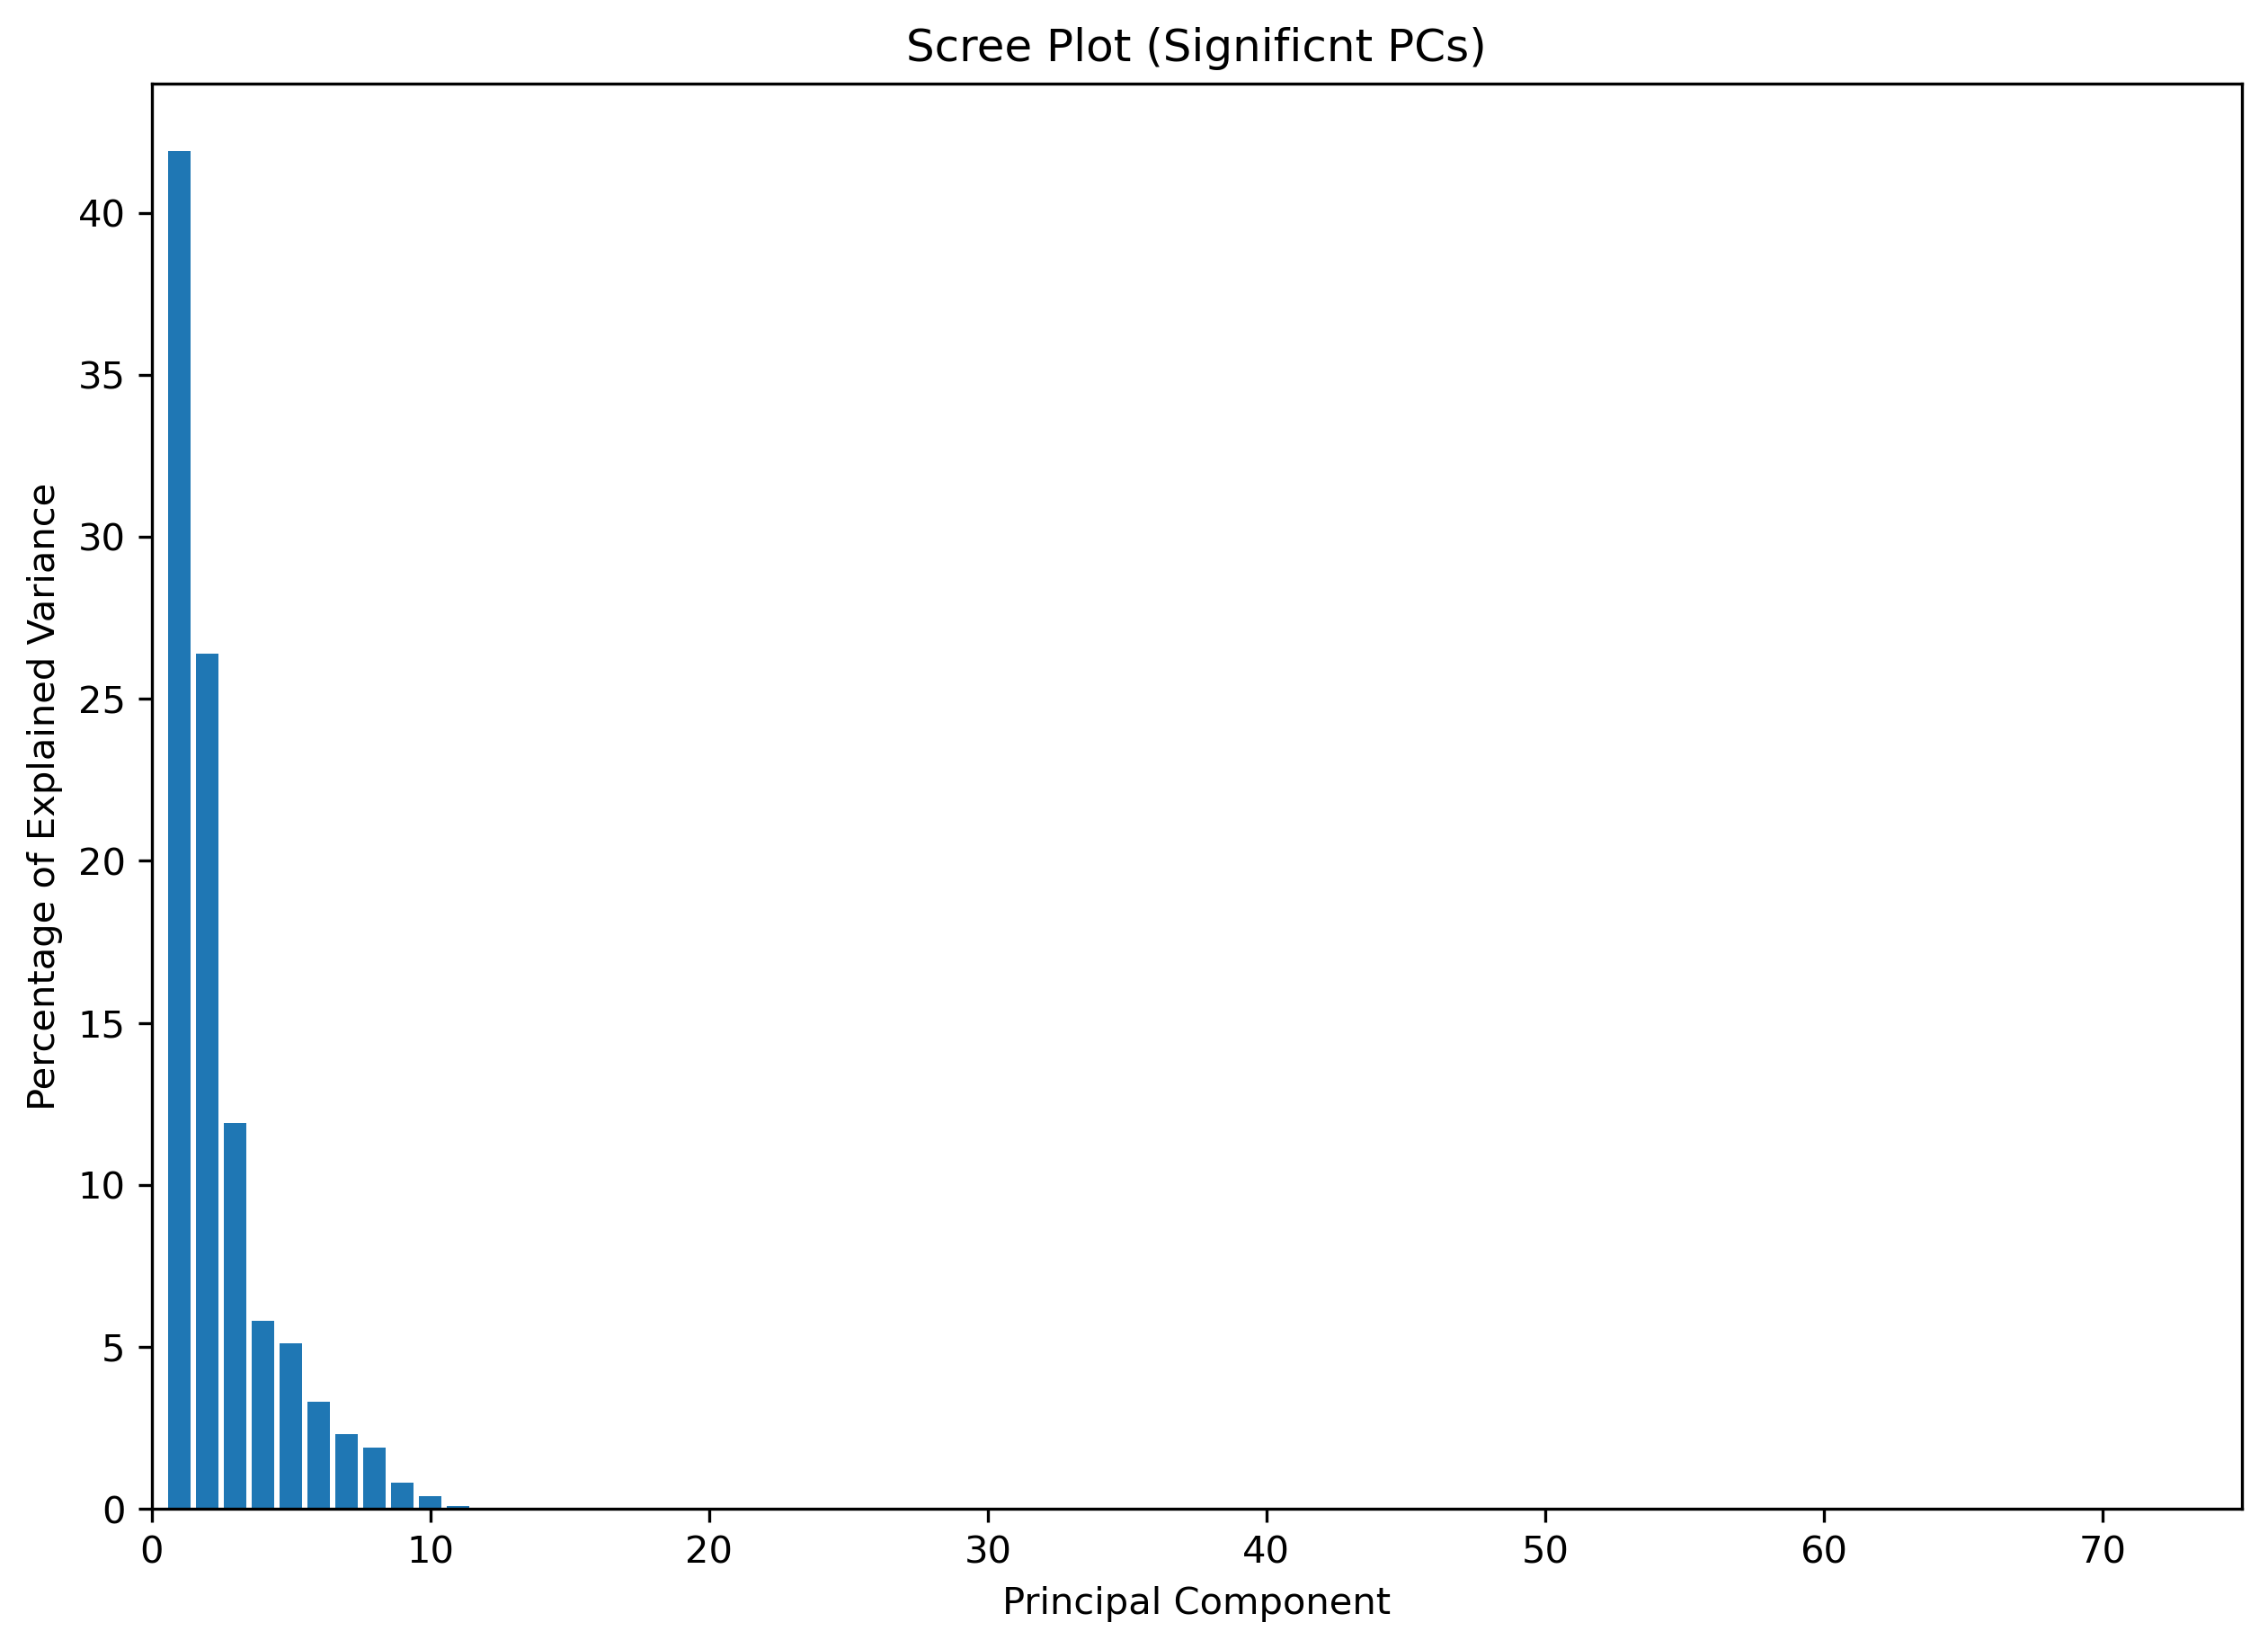

In [23]:
# get scree plot

high_pca = PCA(n_components=12)
high_pca.fit_transform(X_standard)

#calculate percentage of variation in each principal components
per_var=np.round(high_pca.explained_variance_ratio_*100, decimals=1)
PClabels =['PC' + str(x) for x in range(1,len(per_var)+1)]

fig = plt.figure(figsize=(10,7),dpi=300);
plt.bar(x=range(1, len(per_var)+1),height=per_var) #, tick_label=PClabels
plt.title('Scree Plot')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.show()
#zoom in on the important PCs
fig = plt.figure(figsize=(10,7),dpi=300);
plt.bar(x=range(1, len(per_var)+1),height=per_var) #, tick_label=PClabels
plt.title('Scree Plot (Significnt PCs)')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.xlim(0,75)
plt.show()

In [24]:
principalDf['area'] = X[:,0]
principalDf['eccentricity'] = X[:,1]
principalDf['equivalent_diameter'] = X[:,2]
principalDf['major_axis_length'] = X[:,3]
principalDf['minor_axis_length'] = X[:,4]
principalDf['perimeter'] = X[:,5]
principalDf['K'] = X[:,6]
principalDf['P'] = X[:,7]
principalDf['Ni'] = X[:,8]
principalDf['Zn'] = X[:,9]
principalDf['Fe'] = X[:,10]
principalDf['Cu'] = X[:,11]
principalDf['BFY'] = X[:,12]

In [25]:
print(principalDf['area'].max())
print(principalDf['eccentricity'].max())
print(principalDf['equivalent_diameter'].max())
print(principalDf['major_axis_length'].max())
print(principalDf['minor_axis_length'].max())
print(principalDf['perimeter'] .max())
print(principalDf['K'].max())
print(principalDf['P'].max()) 
print(principalDf['Ni'].max()) 
print(principalDf['Zn'].max()) 
print(principalDf['Fe'].max()) 
print(principalDf['Cu'].max()) 
print(principalDf['BFY'].max()) 

4.125
0.9769395940802652
2.2917489221187703
4.373612352851659
2.4812696957111178
10.321067811865476
0.0008107276516966522
0.0003068469522986561
0.00012132191477576271
0.008068055845797062
0.000182758885785006
0.008068055845797062
0.025465836748480797


In [26]:
print(principalDf['area'].median())
print(principalDf['eccentricity'].median())
print(principalDf['equivalent_diameter'].median())
print(principalDf['major_axis_length'].median())
print(principalDf['minor_axis_length'].median())
print(principalDf['perimeter'] .median())
print(principalDf['K'].median())
print(principalDf['P'].median()) 
print(principalDf['Ni'].median()) 
print(principalDf['Zn'].median()) 
print(principalDf['Fe'].median()) 
print(principalDf['Cu'].median()) 
print(principalDf['BFY'].median()) 

0.6875
0.7559289460184544
0.9356025796273888
1.1281521496355325
0.7371064447728443
2.414213562373095
4.2070010749739595e-05
4.344635453890078e-05
4.0804767195368186e-05
0.0009462687594350427
6.080284765630495e-05
0.0009462687594350427
0.01471087895333767


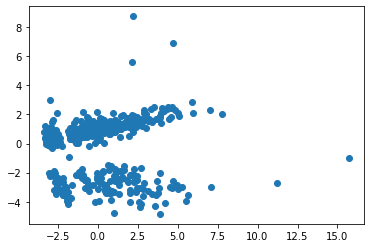

In [27]:
plt.scatter(principalDf['PC1'],principalDf['PC2'])

In [47]:
# Group 1
True_list = principalDf.loc[
    (principalDf['eccentricity'] > 0) &
    (principalDf['eccentricity'] <= 0.7)
    
   ].index.tolist()
print( len(True_list) )

114


In [48]:
True_list

[6,
 7,
 11,
 15,
 18,
 22,
 31,
 32,
 42,
 49,
 51,
 52,
 62,
 63,
 73,
 74,
 75,
 95,
 97,
 99,
 104,
 109,
 110,
 113,
 121,
 122,
 128,
 130,
 132,
 133,
 136,
 148,
 157,
 167,
 168,
 169,
 173,
 174,
 175,
 177,
 181,
 184,
 187,
 189,
 195,
 197,
 218,
 220,
 226,
 236,
 237,
 241,
 246,
 247,
 248,
 252,
 254,
 255,
 259,
 266,
 269,
 272,
 277,
 291,
 296,
 297,
 302,
 306,
 309,
 313,
 321,
 330,
 332,
 333,
 344,
 346,
 351,
 354,
 359,
 366,
 369,
 371,
 375,
 376,
 381,
 384,
 386,
 387,
 390,
 393,
 395,
 413,
 420,
 425,
 433,
 434,
 440,
 447,
 448,
 449,
 462,
 465,
 468,
 470,
 472,
 475,
 485,
 489,
 492,
 502,
 504,
 506,
 518,
 542]

In [49]:
def viewer(idx):

    plt.imshow(X_bin[idx]);

    
    plt.title('Binary image')
    plt.colorbar()
#     plt.ylim(-0.5, 5)
#     plt.grid(True)
    plt.show()

interactive_plot = interactive(viewer, idx=(0, len(X_bin)-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=276, description='idx', max=553), Output()), _dom_classes=('widget-inter…

In [28]:
# now create mult label data frame with strict conditions

labels = [0] * X.shape[0]


# the artifact criterion Group 0

True_list = principalDf.loc[
    (principalDf['eccentricity'] == 0)
    
   ].index.tolist()

print( len(True_list) )
principalDf['text_labels'] = labels

for idx in True_list:
    labels[idx]='Group 0: Artifact, e = 0'

# Group 1
True_list = principalDf.loc[
    (principalDf['eccentricity'] > 0) &
    (principalDf['eccentricity'] <= 0.7)
    
   ].index.tolist()
print( len(True_list) )

for idx in True_list:
    labels[idx]='Group 1: e <0.7'
    
# Group 2 (live)
K_threshold=4.2e-05 #default is median
KbyP_threshold=1 #default is median
True_list = principalDf.loc[
    (principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) &
    (principalDf['K']>=principalDf['K'].median()) &
    (principalDf['K']/principalDf['P']>=(principalDf['K']/principalDf['P']).median())
   ].index.tolist()

print( len(True_list) )

for idx in True_list:
    labels[idx]='Group 2: Shape + Live'
    
# Group 3 (Dead)
Ni_threshold=2.04e-05 #default is half of median
NibyP_threshold=0.48 #default is half of median

NibyZn_threshold=0.021 #default is half of median
NibyFe_threshold=0.32 #default is half of median
NibyK_threshold=0.485 #default is half of median
CubyK_threshold=13 #default is half of median

True_list = principalDf.loc[
    (principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) &
    (principalDf['Ni']>=0.25*principalDf['Ni'].median()) &
    (principalDf['Ni']/principalDf['P']>= 0.25*(principalDf['Ni']/principalDf['P']).median()) &
    (principalDf['Ni']/principalDf['Zn']>= 0.25*(principalDf['Ni']/principalDf['Zn']).median()) &
    (principalDf['Ni']/principalDf['Fe']>= 0.25*(principalDf['Ni']/principalDf['Fe']).median()) &
    (principalDf['Ni']/principalDf['K']>= 0.25*(principalDf['Ni']/principalDf['K']).median()) &
    (principalDf['Cu']/principalDf['K']>= 0.25*(principalDf['Cu']/principalDf['K']).median())
   ].index.tolist()    
    
print( len(True_list) )

for idx in True_list:
    labels[idx]='Group 3: Shape + Dead' 
    

    
    
# the eccentricity criterion

# True_list = principalDf.loc[
#     (principalDf['eccentricity'] >= 0.5) &
#     (principalDf['eccentricity'] <= 0.6) &
#     (principalDf['major_axis_length']<= 0.875)
#    ].index.tolist()

# print( len(True_list) )

# for idx in True_list:
#     labels[idx]='Group 4: 0.5 <= e <=0.6, l<=0.975'
    

for idx in range(len(labels)):
    if labels[idx] ==0:
        labels[idx] = 'Group 4: outlier/undetermined'
    
principalDf['text_labels'] = labels


132
114
128
245


In [29]:
(principalDf['K']/principalDf['P']).median()

1.115593513658345

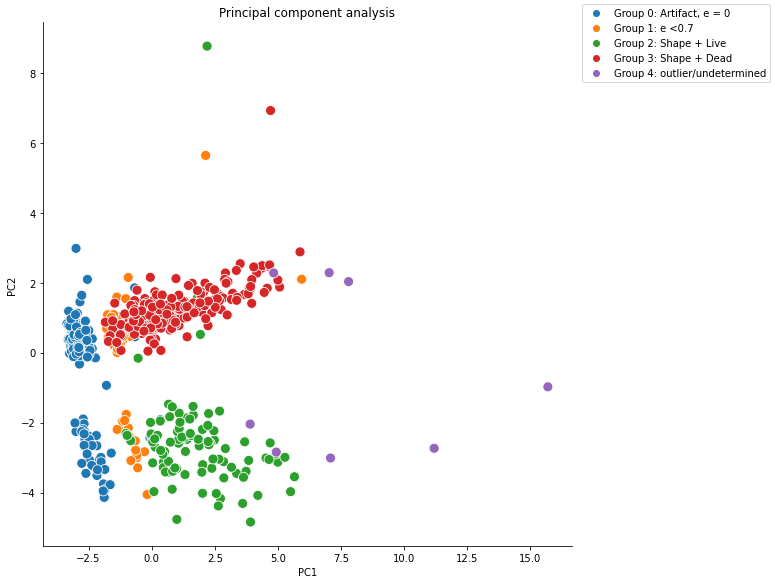

In [30]:
pp = sns.pairplot(data=principalDf.sort_values(by = 'text_labels'),
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis')



In [31]:
# now create mult label data frame with strict conditions

labels = [0] * X.shape[0]

# Group 1 (artifacts)

for idx in range(len(labels)):
    if labels[idx] ==0:
        labels[idx] = 'artifacts/background/outlier'

    
# Group 2 (live)
K_threshold=4.2e-05 #default is median
KbyP_threshold=1 #default is median
True_list = principalDf.loc[
    (principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) &
    (principalDf['K']>=principalDf['K'].median()) &
    (principalDf['K']/principalDf['P']>=(principalDf['K']/principalDf['P']).median())
   ].index.tolist()

print( len(True_list) )

for idx in True_list:
    labels[idx]='live cells'
    
# Group 3 (Dead)
Ni_threshold=2.04e-05 #default is half of median
NibyP_threshold=0.48 #default is half of median

NibyZn_threshold=0.021 #default is half of median
NibyFe_threshold=0.32 #default is half of median
NibyK_threshold=0.485 #default is half of median
CubyK_threshold=13 #default is half of median

True_list = principalDf.loc[
    (principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) &
    (principalDf['Ni']>=0.25*principalDf['Ni'].median()) &
    (principalDf['Ni']/principalDf['P']>= 0.25*(principalDf['Ni']/principalDf['P']).median()) &
    (principalDf['Ni']/principalDf['Zn']>= 0.25*(principalDf['Ni']/principalDf['Zn']).median()) &
    (principalDf['Ni']/principalDf['Fe']>= 0.25*(principalDf['Ni']/principalDf['Fe']).median()) &
    (principalDf['Ni']/principalDf['K']>= 0.25*(principalDf['Ni']/principalDf['K']).median()) &
    (principalDf['Cu']/principalDf['K']>= 0.25*(principalDf['Cu']/principalDf['K']).median())
   ].index.tolist()    
    
print( len(True_list) )

for idx in True_list:
    labels[idx]='dead cells' 
    


    
principalDf['text_labels'] = labels


128
245


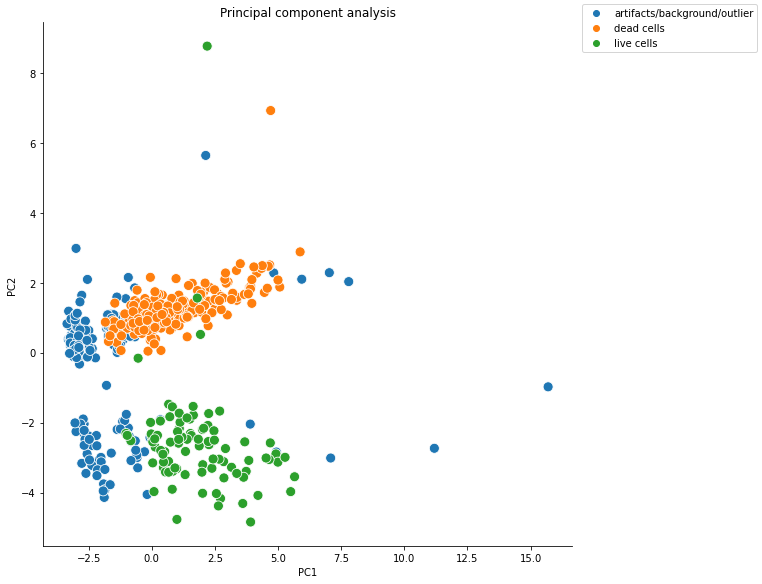

In [32]:
pp = sns.pairplot(data=principalDf.sort_values(by = 'text_labels'),
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis')



In [33]:
principalDf

,PC1,PC2,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,Zn,Fe,Cu,BFY,text_labels
0,-2.963312,0.271561,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000029,0.000030,0.000029,0.001002,0.000071,0.001002,0.015246,artifacts/background/outlier
1,-2.886770,0.146646,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000029,0.000030,0.000043,0.000768,0.000062,0.000768,0.015790,artifacts/background/outlier
2,-2.564881,0.349637,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000030,0.000045,0.000043,0.001093,0.000095,0.001093,0.018312,artifacts/background/outlier
3,2.740350,1.607484,1.3125,0.846038,1.292721,1.764861,0.940886,3.828427,0.000045,0.000083,0.000058,0.001371,0.000059,0.001371,0.016610,dead cells
4,1.330496,1.099449,1.0625,0.945978,1.163107,2.102629,0.681738,2.267767,0.000045,0.000041,0.000055,0.001019,0.000076,0.001019,0.017674,dead cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,4.917267,-2.896002,1.5625,0.941817,1.410474,2.474690,0.831810,5.035534,0.000437,0.000122,0.000056,0.000059,0.000095,0.000059,0.005291,live cells
550,15.693342,-0.978194,4.1250,0.780748,2.291749,3.971010,2.481270,10.321068,0.000446,0.000147,0.000066,0.000099,0.000125,0.000099,0.005216,artifacts/background/outlier
551,0.460987,-3.287474,0.6875,0.819334,0.935603,1.241999,0.712058,2.267767,0.000449,0.000102,0.000034,0.000064,0.000068,0.000064,0.004908,live cells
552,-1.855388,-3.919492,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000313,0.000101,0.000029,0.000031,0.000116,0.000031,0.004815,artifacts/background/outlier


In [34]:
## plot the gradients

In [35]:
test_pd = principalDf

In [36]:


test_pd.PC2.diff()

0           NaN
1     -0.124914
2      0.202990
3      1.257847
4     -0.508035
         ...   
549    0.555980
550    1.917809
551   -2.309280
552   -0.632018
553    1.094391
Name: PC2, Length: 554, dtype: float64

In [37]:
dPC1_dPC2=(test_pd.PC1.diff()/test_pd.PC2.diff()).to_numpy()

In [38]:
dP_dK=(test_pd.P.diff()/test_pd.K.diff()).to_numpy()

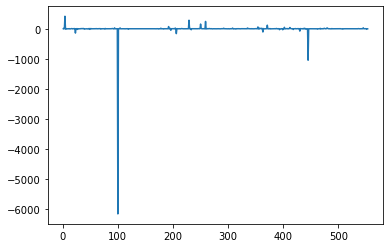

In [39]:
plt.plot(dP_dK)

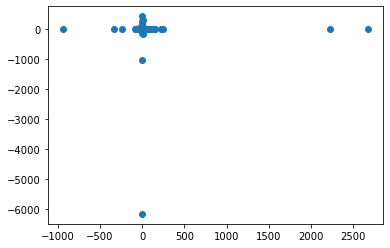

In [40]:
plt.scatter(dPC1_dPC2,dP_dK)

In [44]:
test_pd['dPC1_dPC2'] = (test_pd.PC1.diff()/test_pd.PC2.diff()).to_numpy()

test_pd['dP_dK'] = (test_pd.P.diff()/test_pd.K.diff()).to_numpy()

In [46]:


with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(test_pd)

,PC1,PC2,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,Zn,Fe,Cu,BFY,text_labels,dPC1_dPC2,dP_dK
0,-2.963312,0.271561,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000029,0.000030,0.000029,0.001002,0.000071,0.001002,0.015246,artifacts/background/outlier,NaN,NaN
1,-2.886770,0.146646,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000029,0.000030,0.000043,0.000768,0.000062,0.000768,0.015790,artifacts/background/outlier,-0.612752,-0.416895
2,-2.564881,0.349637,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000030,0.000045,0.000043,0.001093,0.000095,0.001093,0.018312,artifacts/background/outlier,1.585737,15.224069
3,2.740350,1.607484,1.3125,0.846038,1.292721,1.764861,0.940886,3.828427,0.000045,0.000083,0.000058,0.001371,0.000059,0.001371,0.016610,dead cells,4.217706,2.584520
4,1.330496,1.099449,1.0625,0.945978,1.163107,2.102629,0.681738,2.267767,0.000045,0.000041,0.000055,0.001019,0.000076,0.001019,0.017674,dead cells,2.775111,416.373169
5,-2.546101,-0.125563,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000043,0.000056,0.000048,0.000818,0.000080,0.000818,0.016637,artifacts/background/outlier,3.164538,-13.545476
6,2.921046,2.275645,1.4375,0.579046,1.352879,1.519026,1.238454,3.974874,0.000041,0.000040,0.000043,0.001565,0.000070,0.001565,0.016977,dead cells,2.276832,5.459190
7,-0.638324,0.555530,0.5000,0.577350,0.797885,0.866025,0.707107,1.914214,0.000029,0.000088,0.000083,0.001170,0.000059,0.001170,0.015875,artifacts/background/outlier,2.069263,-4.150893
8,-1.463214,1.413595,0.5000,0.816497,0.797885,1.060660,0.612372,1.414214,0.000052,0.000053,0.000031,0.001614,0.000053,0.001614,0.017166,dead cells,-0.961337,-1.524047
9,1.018375,1.423899,0.8750,0.829925,1.055502,1.414214,0.788954,2.974874,0.000044,0.000061,0.000061,0.001335,0.000071,0.001335,0.018209,dead cells,240.843895,-0.944614


In [ ]:
#end